In [124]:
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import pickle
import PIL as pillow
from tqdm import tqdm
import numpy as np
import seaborn as sns
import scipy.stats as spst
import scipy
from statannotations.Annotator import Annotator
import time
from pathlib import Path
import argparse
from matplotlib.gridspec import GridSpec
from matplotlib.transforms import Affine2D
import baisic_plot_fuctnions_and_features as bpf
import warnings
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
bpf.set_plot_properties()

vlinec = "#C35817"

learner_cell = "2022_12_21_cell_1" 
non_learner_cell = "2023_01_10_cell_1"
time_to_plot = 0.250 # in s 

time_points = ["pre","0", "10", "20","30" ]
selected_time_points = ['post_0', 'post_1', 'post_2', 'post_3','pre']
                        #'post_4','post_5']
cell_dist=[8,10,4]
cell_dist_key = ["leaners","non\nlearners","cells\nnot\ncosidered"]

In [388]:
all_cells_all_trails_extracted_featrues = pd.read_pickle("/Users/anzalks/Documents/pattern_learning_paper/plotting_scripts/python_scripts_paper_ready/analysis_scripts/pickle_files_from_analysis/pd_all_cells_all_trials.pickle")

In [17]:
sc_data_dict = pd.read_pickle("/Users/anzalks/Documents/pattern_learning_paper/plotting_scripts/python_scripts_paper_ready/analysis_scripts/pickle_files_from_analysis/all_cells_fnorm_classifeied_dict.pickle")

In [183]:
curvfit_data = pd.read_hdf("/Users/anzalks/Documents/pattern_learning_paper/plotting_scripts/python_scripts_paper_ready/analysis_scripts/pickle_files_from_analysis/curvefit_results.h5")
curvfit_data =curvfit_data[~curvfit_data["cell_ID"].isin(["2022_12_12_cell_5"])]

In [475]:
def substract_baseline(trace,sampling_rate, bl_period_in_ms):
    bl_period = bl_period_in_ms/1000
    bl_duration = int(sampling_rate*bl_period)
    bl = np.mean(trace[:bl_duration])
    bl_trace = trace-bl
    return bl_trace

In [193]:
crv_df =curvfit_data.copy()
list_learners = sc_data_dict["ap_cells"]["cell_ID"].unique()
list_non_learners = sc_data_dict["an_cells"]["cell_ID"].unique()
def categorize_cell_id(cell_id):
    if cell_id in list_learners:
        return 'learners'
    elif cell_id in list_non_learners:
        return 'non_learners'
    else:
        return cell_id

In [194]:
crv_df['cell_ID'] = crv_df['cell_ID'].apply(categorize_cell_id)

In [201]:
crv_df = crv_df[(crv_df["pre_post_status"].isin(["pre","post_3"]))&(crv_df["cell_ID"].isin(["learners","non_learners"]))]

In [202]:
def plot_pca_comparison(df):
    # Select numeric columns for PCA
    numeric_cols = ['Epk', 'Etau', 'Ipk', 'Itau', 'delay', 'initDelay']
    X = df[numeric_cols]

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform PCA
    pca = PCA(n_components=4)  # Choose the number of components you want to visualize
    X_pca = pca.fit_transform(X_scaled)

    # Create a DataFrame for PCA results
    pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
    pca_df = pd.concat([df[['cell_ID', 'pre_post_status']], pca_df], axis=1)

    # Visualize the results using pair plot
    sns.pairplot(pca_df, hue='cell_ID', diag_kind='kde', markers=['o', 's'])
    plt.suptitle(f'Pair Plot of PCA Results', y=1.02)
    plt.show()

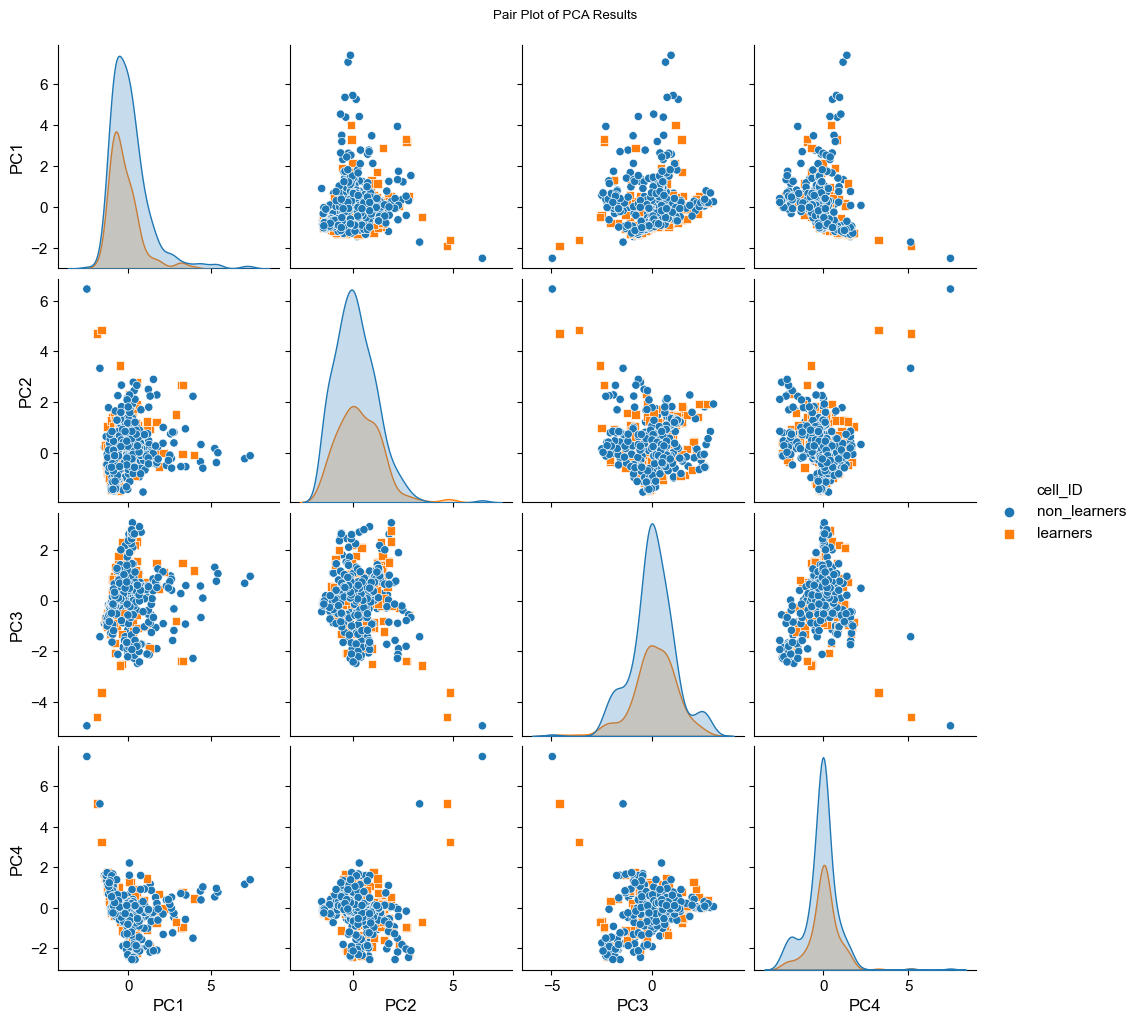

In [203]:
# Load your DataFrame (assuming you have it in a CSV file)
#lrn = curvfit_data[(curvfit_data["pre_post_status"].isin(["pre","post_3"]))&(curvfit_data["cell_ID"].isin(learners))]
#nlrn = curvfit_data[(curvfit_data["pre_post_status"].isin(["pre","post_3"]))&(curvfit_data["cell_ID"].isin(non_learners))]
plot_pca_comparison(crv_df)

In [112]:
def plot_curve_fit_feature(curvfit_data,sc_data_dict, feature_to_plot):
    fig,axs_all=plt.subplots(1,3)
    data_min,data_max = curvfit_data[feature_to_plot].min(),curvfit_data[feature_to_plot].max()
    
    cell_grp = curvfit_data.groupby(by="cell_ID")
    learners = sc_data_dict["ap_cells"]["cell_ID"].unique()
    non_learners = sc_data_dict["an_cells"]["cell_ID"].unique()
    time_points = ["pre","post_3"]
    for cell,cell_data in cell_grp:
        if cell =="2022_12_12_cell_5":
            continue
        if cell in learners:
            color='b'
        elif cell in non_learners:
            color='r'
        else:
            continue
        cell_data =cell_data[cell_data["pre_post_status"].isin(time_points)]
        #print(f"cell_data:{cell_data}")
        trial_grp = cell_data.groupby(by="trial_no")
        for trial,trial_data in trial_grp:
            frame_grp = trial_data.groupby(by="frame_id")
            for frame, frame_data in frame_grp:
                if "pattern" not in frame:
                    continue
                axs=axs_all[int(frame.split('_')[-1])]
                pre_data = frame_data[frame_data["pre_post_status"]=="pre"][feature_to_plot].values
                post_data = frame_data[frame_data["pre_post_status"]=="post_3"][feature_to_plot].values
                #print(pre_data,post_data)
                axs.set_title(frame)
                axs.scatter(pre_data,post_data, color=color)
                axs.set_ylim(data_min,data_max)
                axs.set_xlim(data_min,data_max)
                axs.set_ylabel("post")
                axs.set_xlabel("pre")
                axs.set_aspect("equal")
    plt.suptitle(f"feature_to_plot: {feature_to_plot}")
    plt.tight_layout()
    plt.show()

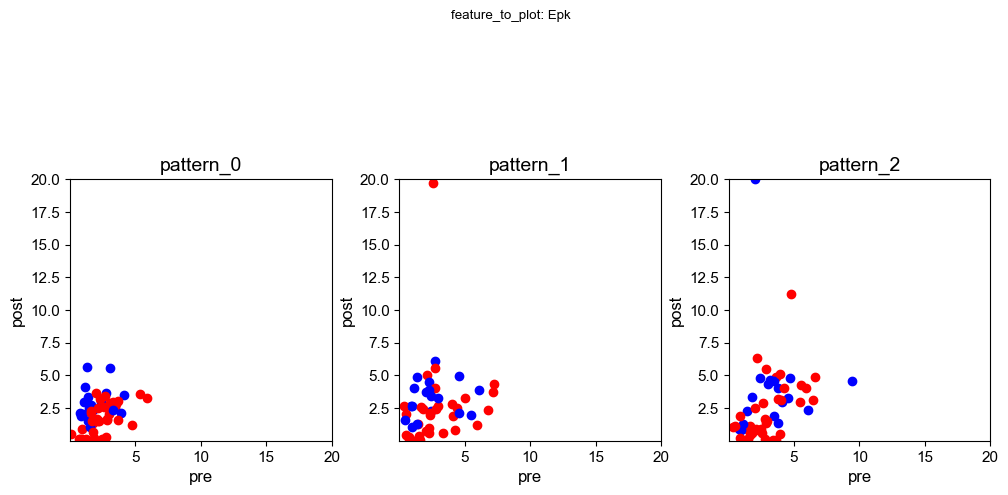

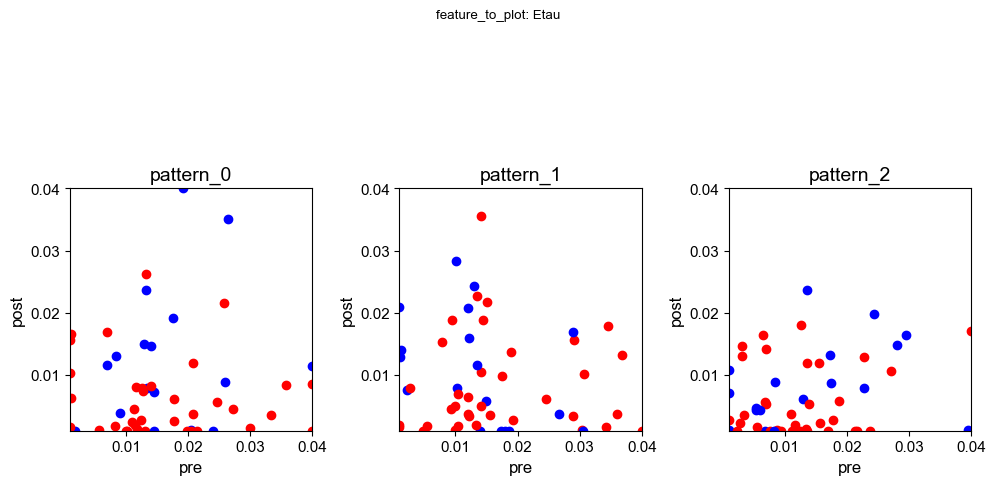

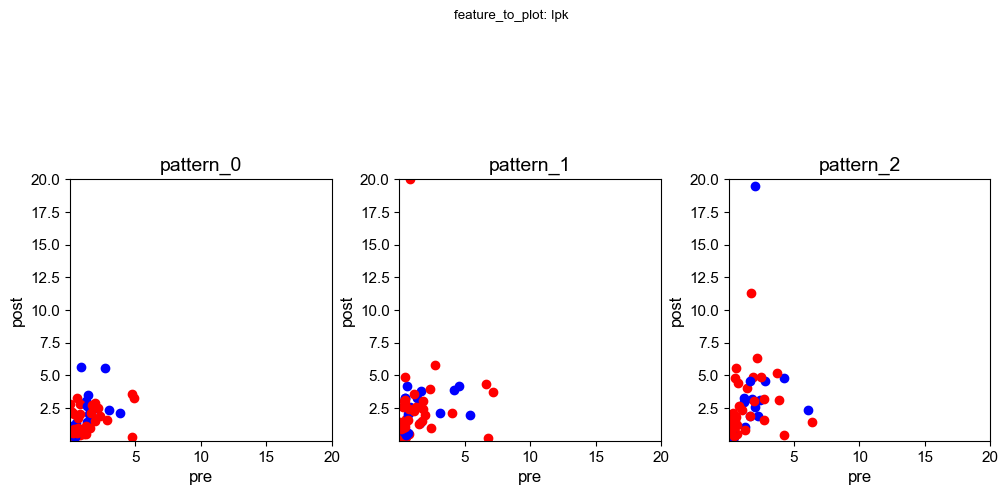

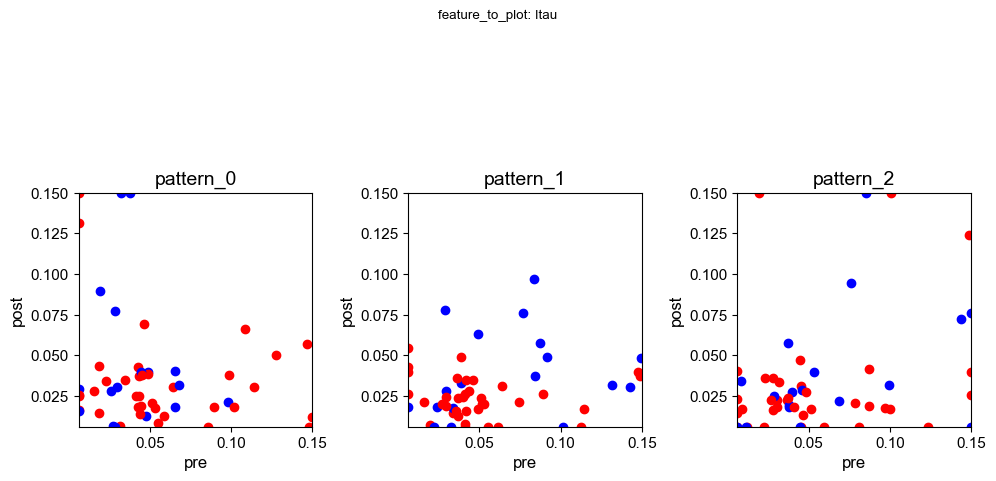

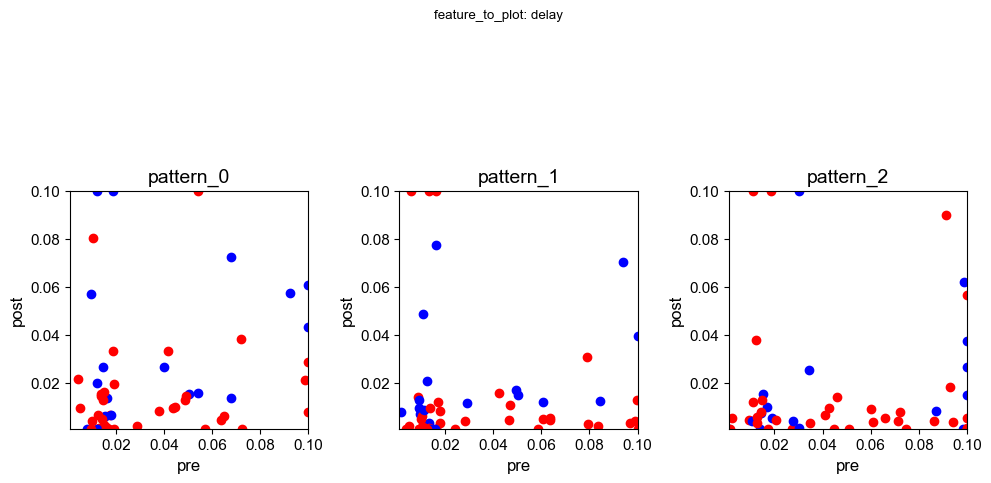

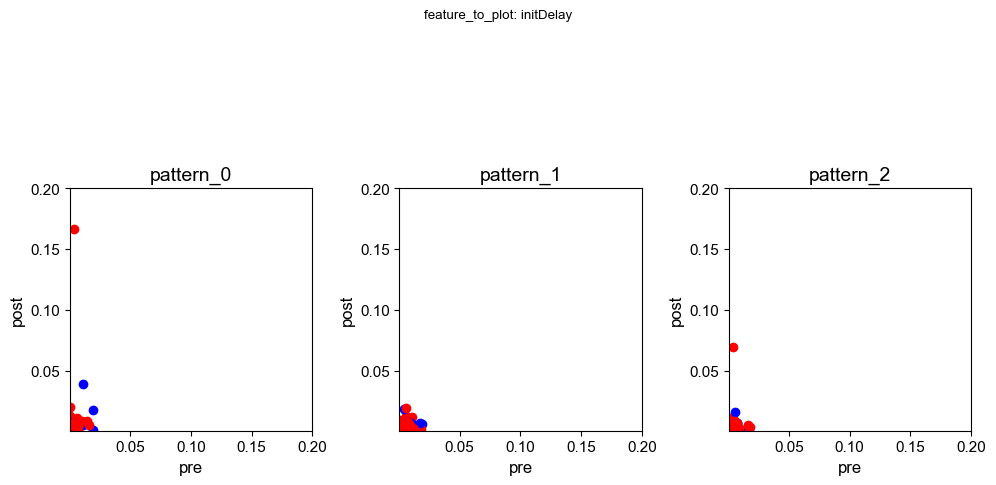

In [113]:
features =["Epk","Etau","Ipk","Itau","delay","initDelay"]
for feature in features:
    plot_curve_fit_feature(curvfit_data,sc_data_dict, feature)

In [121]:
time_points = ["pre","0", "10", "20","30" ]
def norm_values(cell_list,val_to_plot):
    cell_list = cell_list.copy()
    #print(f"cell list inside func : {cell_list}")
    cell_grp=cell_list.groupby(by="cell_ID")
    for c, cell in cell_grp:
        pat_grp = cell.groupby(by="frame_id")
        for p,pat in pat_grp:
            #print(f"c:{c}, p:{p}")
            pre_val= cell[(cell["cell_ID"]==c)&(cell["frame_id"]==p)&(cell["pre_post_status"]=="pre")][val_to_plot].values
            pp_grp = pat.groupby(by="pre_post_status")
            for pr, pp in pp_grp:
                norm_val = cell[(cell["cell_ID"]==c)&(cell["frame_id"]==p)&(cell["pre_post_status"]==pr)][val_to_plot].values
                norm_val = (norm_val/pre_val)*100
                cell_list.loc[(cell_list["cell_ID"]==c)&(cell_list["frame_id"]==p)&(cell_list["pre_post_status"]==pr),val_to_plot]=norm_val
    return cell_list
   

def norm_values_all_trials(cell_list, val_to_plot):
    cell_list = cell_list.copy()
    # Group by 'cell_ID'
    cell_grp = cell_list.groupby(by="cell_ID")
    for c, cell in cell_grp:
        pat_grp = cell.groupby(by="frame_id")
        for p, pat in pat_grp:
            trial_grp = pat.groupby(by="trial_no")
            for trial, trial_data in trial_grp:
                pre_val = trial_data[trial_data["pre_post_status"] == "pre"][val_to_plot].values
                if len(pre_val) == 0:
                    continue
                else:
                    pre_val = pre_val[0]  # Assuming there is only one 'pre' value per group
                    pp_grp = trial_data.groupby(by="pre_post_status")
                    for pr, pp in pp_grp:
                        norm_val = pp[val_to_plot].values
                        norm_val = (norm_val / pre_val) * 100
                        # Using vectorized operations for efficiency
                        mask_cell_ID = cell_list["cell_ID"] == c
                        mask_frame_id = cell_list["frame_id"] == p
                        mask_pre_post_status = cell_list["pre_post_status"] == pr
                        mask_trial_no = cell_list["trial_no"] == trial
                        combined_mask = mask_cell_ID & mask_frame_id & mask_pre_post_status & mask_trial_no
                        cell_list.loc[combined_mask, val_to_plot] = norm_val
    return cell_list

def plot_cell_dist(catcell_dist,val_to_plot,fig,axs,pattern_number,y_lim,
                   x_label, cell_type,plt_color,resp_color):
    pat_num=int(pattern_number.split("_")[-1])
    num_cells= len(catcell_dist["cell_ID"].unique())
    pfd = catcell_dist.groupby(by="frame_id")
    for c, pat in pfd:
        if c != pattern_number:
            continue
        else:
            order = np.array(('pre','post_0','post_1','post_2','post_3'),dtype=object)
            g=sns.stripplot(data=pat, x="pre_post_status",y=f"{val_to_plot}",
                            order=order,ax=axs,color=resp_color,
                            alpha=0.6,size=8, label='cell response')#alpha=0.8,
            sns.pointplot(data=pat, x="pre_post_status",y=f"{val_to_plot}",
                          errorbar="se",order=order,capsize=0.08,ax=axs,
                          color=plt_color, linestyles='dotted',scale = 0.8,
                         label="average cell response")
            g.set_title(None)
            #"""
            pvalList = []
            anotp_list = []
            for i in order[1:]:
                posti ="post{i}"
                #non parametric, paired and small sample size, hence used Wilcoxon signed-rank test
                #Wilcoxon signed-rank test
                posti= spst.wilcoxon(pat[pat["pre_post_status"]=='pre'][f"{val_to_plot}"],pat[pat["pre_post_status"]==i][f"{val_to_plot}"],
                                     zero_method="wilcox", correction=True)
                pvalList.append(posti.pvalue)
                anotp_list.append(("pre",i))
            annotator = Annotator(axs,anotp_list,data=pat, 
                                  x="pre_post_status",
                                  y=f"{val_to_plot}",
                                  order=order,
                                 fontsize=8)
            #annotator = Annotator(axs[pat_num],[("pre","post_0"),("pre","post_1"),("pre","post_2"),("pre","post_3")],data=cell, x="pre_post_status",y=f"{col_pl}")
            annotator.set_custom_annotations([bpf.convert_pvalue_to_asterisks(a) for a in pvalList])
            annotator.annotate()
            #"""
            axs.axhline(100, ls=':',color="k", alpha=0.4)
            if pat_num==0:
                sns.despine(fig=None, ax=axs, top=True, right=True, 
                            left=False, bottom=False, offset=None, trim=False)
                axs.set_ylabel("% change in\nEPSP amplitude")
                axs.set_xlabel(None)
                #axs[pat_num].set_yticks([])
            elif pat_num==1:
                sns.despine(fig=None, ax=axs, top=True, right=True, 
                            left=False, bottom=False, offset=None, trim=False)
                axs.set_ylabel(None)
                axs.set_yticklabels([])
                if cell_type=="dep_cells":
                    axs.set_xlabel(x_label)
                else:
                    axs.set_xlabel(None)
            elif pat_num==2:
                sns.despine(fig=None, ax=axs, top=True, right=True, 
                            left=False, bottom=False, offset=None, trim=False)
                axs.set_xlabel(None)
                axs.set_ylabel(None)
                axs.set_yticklabels([])
            else:
                pass 
            g.set(ylim=y_lim)
            g.set_xticklabels(time_points,rotation=0)
            g.legend_.remove()
            if cell_type!="dep_cells":
                axs.set_xticklabels([])
            else:
                pass 


    ax_pos = axs.get_position()
    #new_ax_pos = [ax_pos.x0-0.02, ax_pos.y0, ax_pos.width,
    #              ax_pos.height]
    #axs.set_position(new_ax_pos)

def plot_cell_category_classified_EPSP_features(esp_feat_cells_df,val_to_plot,
                                                fig,axs1,axs2,axs3,cell_type):
    cell_df= norm_values(esp_feat_cells_df,val_to_plot)
    if cell_type=="pot_cells":
        strp_color = bpf.CB_color_cycle[0]
        line_color = bpf.CB_color_cycle[5]
        y_lim = (-25,800)
        x_label = None
    elif cell_type=="dep_cells":
        strp_color = bpf.CB_color_cycle[1]
        line_color = bpf.CB_color_cycle[5]
        y_lim = (-200,500)
        x_label = "time points (mins)"
    else:
        print("uncagerised cell")
    plot_cell_dist(cell_df,val_to_plot,fig,axs1,"pattern_0",
                   y_lim,x_label,cell_type,line_color,strp_color
                  )
    plot_cell_dist(cell_df,val_to_plot,fig,axs2,"pattern_1",
                   y_lim,x_label,cell_type,line_color,strp_color
                  )
    plot_cell_dist(cell_df,val_to_plot,fig,axs3,"pattern_2",
                   y_lim,x_label,cell_type,line_color,strp_color
                  )
    plt.suptitle(f"val_to_plot:{val_to_plot}")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: *** p= 0.0
pre vs. post_1: * p= 0.024
pre vs. post_2: * p= 0.021
pre vs. post_3: ** p= 0.002
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: *** p= 0.0
pre vs. post_1: ** p= 0.002
pre vs. post_2: ** p= 0.009
pre vs. post_3: ** p= 0.008
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns


/Users/anzalks/miniconda3/envs/lab_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/anzalks/miniconda3/envs/lab_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns


/Users/anzalks/miniconda3/envs/lab_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ** p= 0.009
pre vs. post_1: * p= 0.03
pre vs. post_2: * p= 0.027
pre vs. post_3: *** p= 0.0
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: * p= 0.014
pre vs. post_2: ns
pre vs. post_3: * p= 0.01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p

/Users/anzalks/miniconda3/envs/lab_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns


/Users/anzalks/miniconda3/envs/lab_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns


/Users/anzalks/miniconda3/envs/lab_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: * p= 0.014
pre vs. post_2: ns
pre vs. post_3: ** p= 0.006
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns


/Users/anzalks/miniconda3/envs/lab_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/anzalks/miniconda3/envs/lab_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns


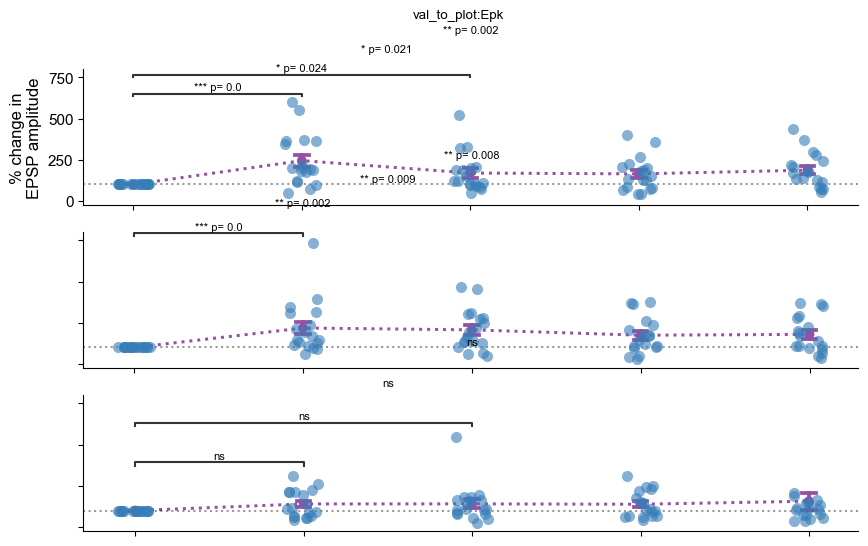

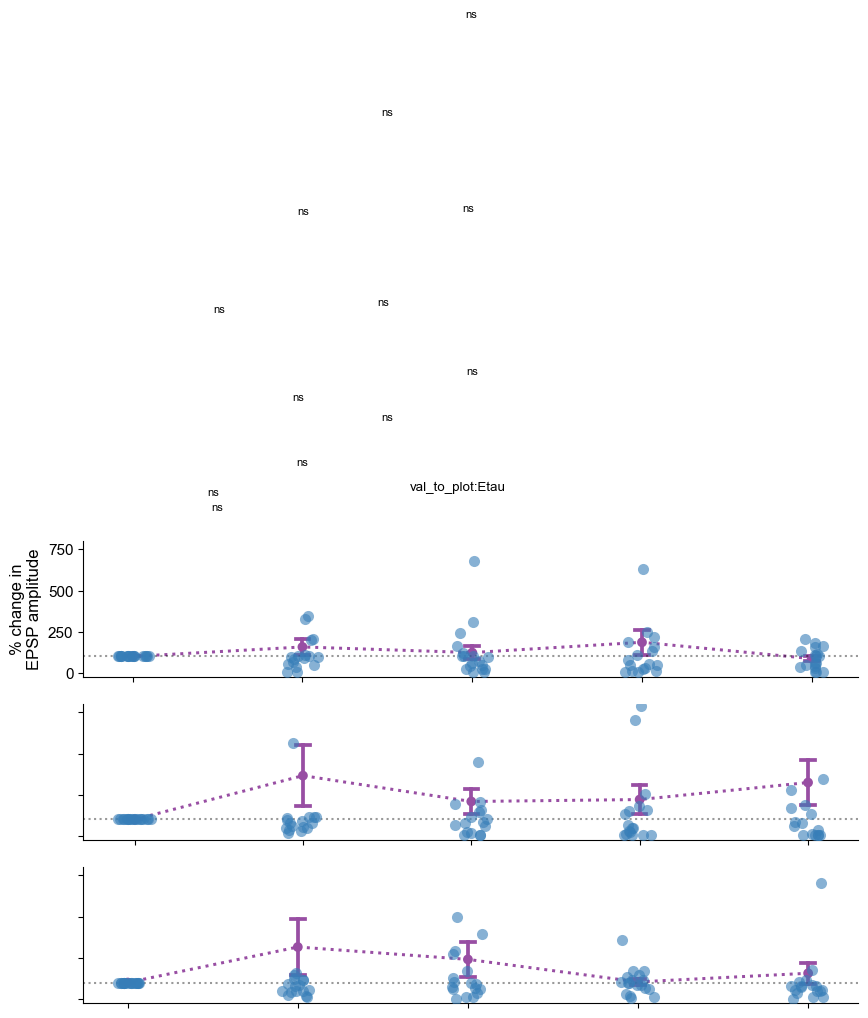

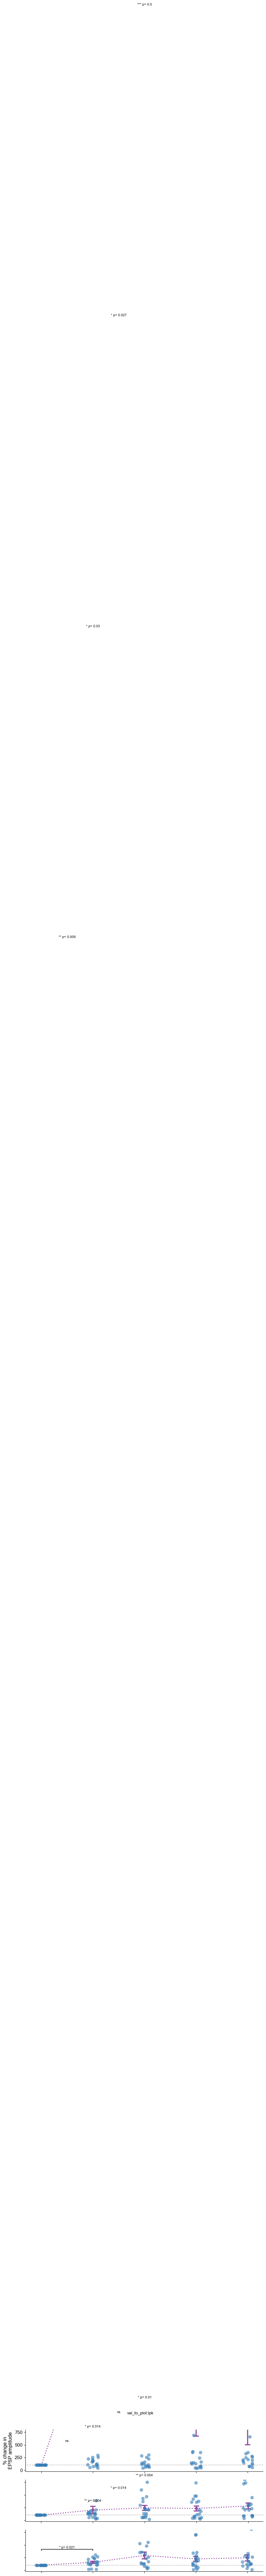

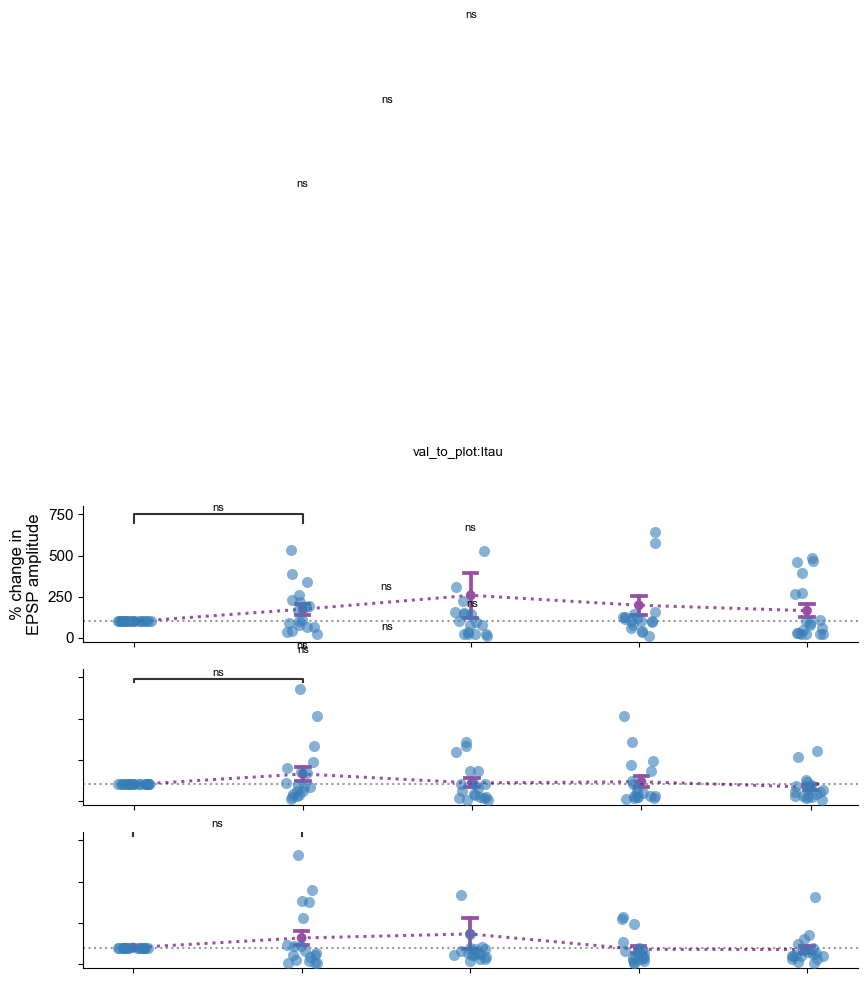

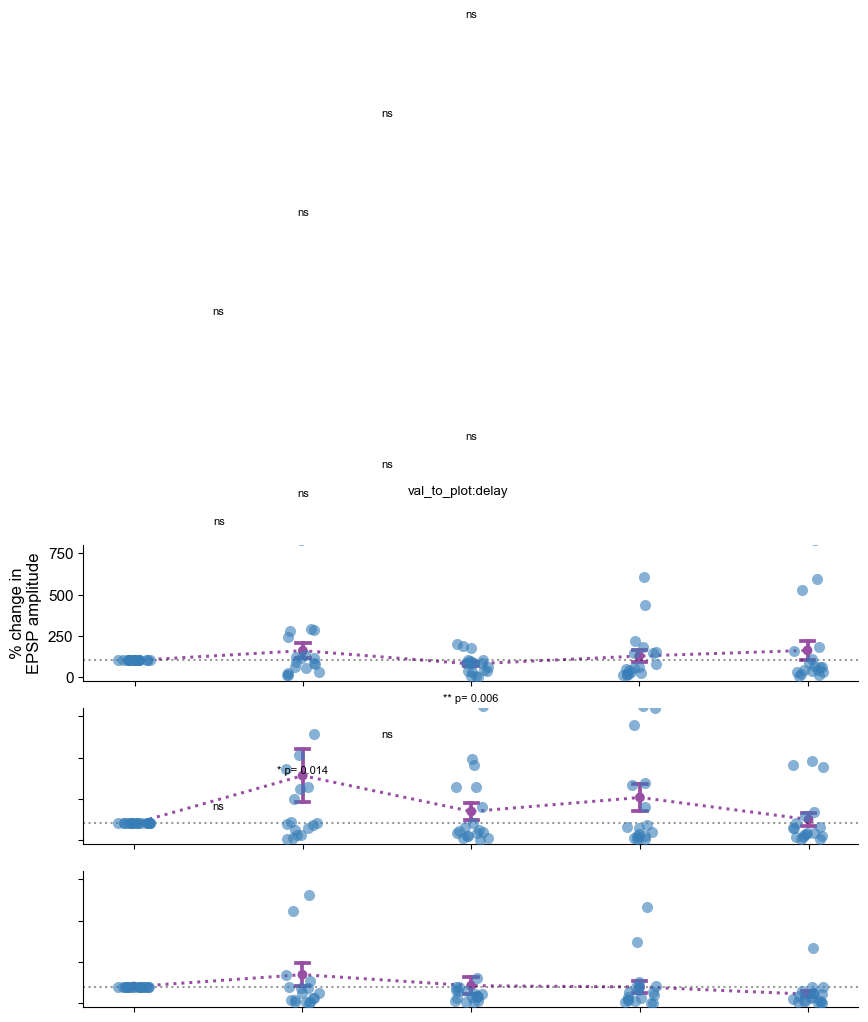

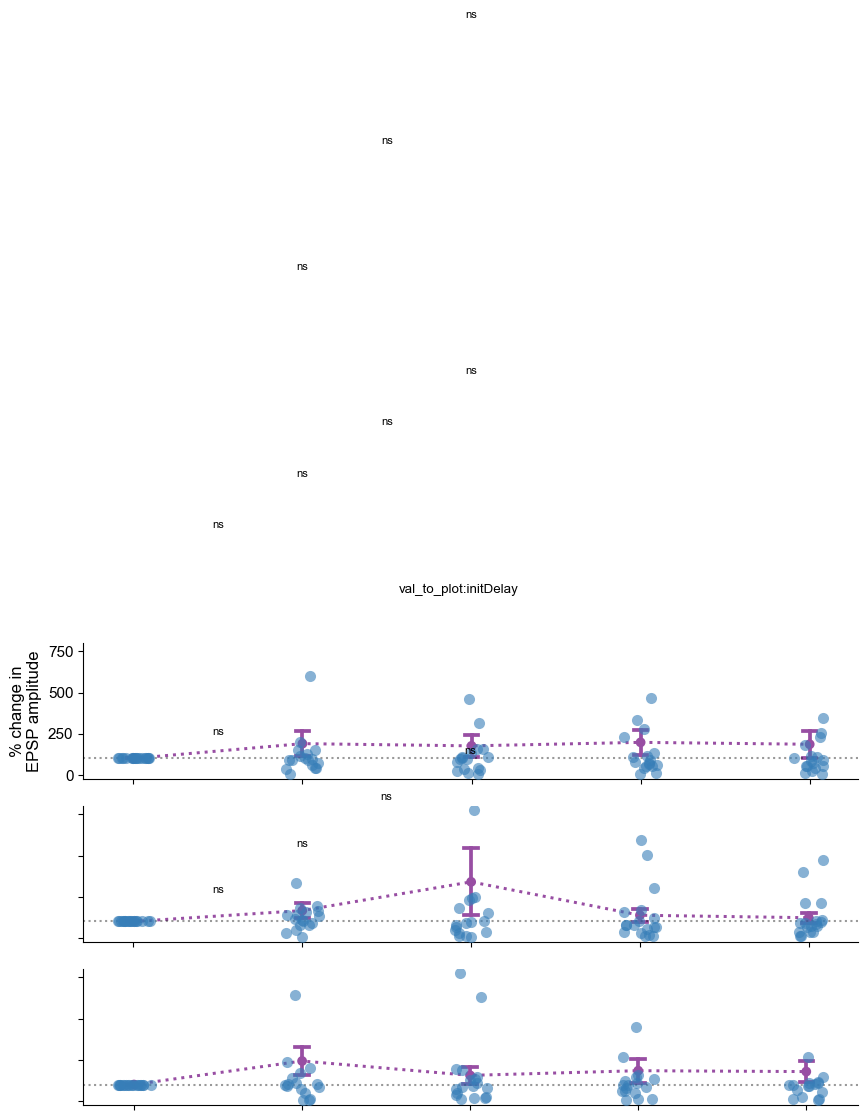

In [122]:
learners = sc_data_dict["ap_cells"]["cell_ID"].unique()
non_learners = sc_data_dict["an_cells"]["cell_ID"].unique()
curv_dat = curvfit_data[curvfit_data["cell_ID"].isin(learners)].reset_index(drop=True)
for feature in features:
    fig, axs=plt.subplots(3,1)
    plot_cell_category_classified_EPSP_features(curv_dat,feature,fig,axs[0],axs[1],axs[2],"pot_cells")

In [119]:
from math import pi

def norm_values(cell_list, val_to_plot):
    cell_list = cell_list.copy()
    cell_grp = cell_list.groupby(by="cell_ID")
    for c, cell in cell_grp:
        pat_grp = cell.groupby(by="frame_id")
        for p, pat in pat_grp:
            trial_grp = pat.groupby(by="trial_no")
            for trial, trial_data in trial_grp:
                pre_val = trial_data[trial_data["pre_post_status"] == "pre"][val_to_plot].values
                if len(pre_val) == 0:
                    continue
                else:
                    pre_val = pre_val[0]  # Assuming there is only one 'pre' value per group
                    pp_grp = trial_data.groupby(by="pre_post_status")
                    for pr, pp in pp_grp:
                        norm_val = pp[val_to_plot].values
                        norm_val = (norm_val / pre_val) * 100
                        # Using vectorized operations for efficiency
                        mask_cell_ID = cell_list["cell_ID"] == c
                        mask_frame_id = cell_list["frame_id"] == p
                        mask_pre_post_status = cell_list["pre_post_status"] == pr
                        mask_trial_no = cell_list["trial_no"] == trial
                        combined_mask = mask_cell_ID & mask_frame_id & mask_pre_post_status & mask_trial_no
                        cell_list.loc[combined_mask, val_to_plot] = norm_val
    return cell_list

def create_radar_plot(data, val_to_plot, cell_type, ax):
    categories = ["pre", "0", "10", "20", "30"]
    num_vars = len(categories)

    # Create the angle for each category
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop

    data = data.groupby("pre_post_status")[val_to_plot].mean().reindex(categories).values
    data = np.append(data, data[:1])  # Complete the loop

    ax.plot(angles, data, linewidth=1, linestyle='solid', label=cell_type)
    ax.fill(angles, data, alpha=0.25)

    ax.set_ylim(0, 200)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)

    ax.set_yticklabels([])

def plot_cell_category_classified_EPSP_features(cell_list, val_to_plot, cell_type):
    cell_df = norm_values(cell_list, val_to_plot)
    categories = cell_df["pre_post_status"].unique()

    fig, axs = plt.subplots(3, 1, subplot_kw=dict(polar=True), figsize=(8, 12))

    if cell_type == "pot_cells":
        color = "blue"
    elif cell_type == "dep_cells":
        color = "red"
    else:
        print("uncategorized cell")
        return

    for i, ax in enumerate(axs):
        pattern_number = f"pattern_{i}"
        pat_data = cell_df[cell_df["frame_id"] == pattern_number]
        create_radar_plot(pat_data, val_to_plot, cell_type, ax)

    plt.suptitle(f"{val_to_plot} Radar Plot for {cell_type}")
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.show()


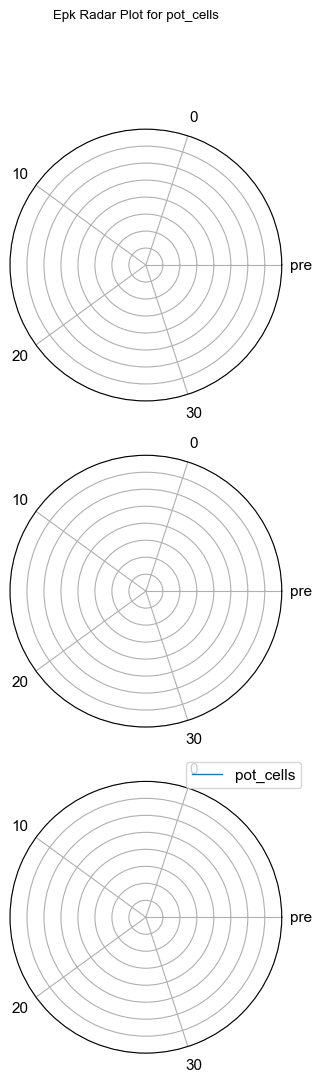

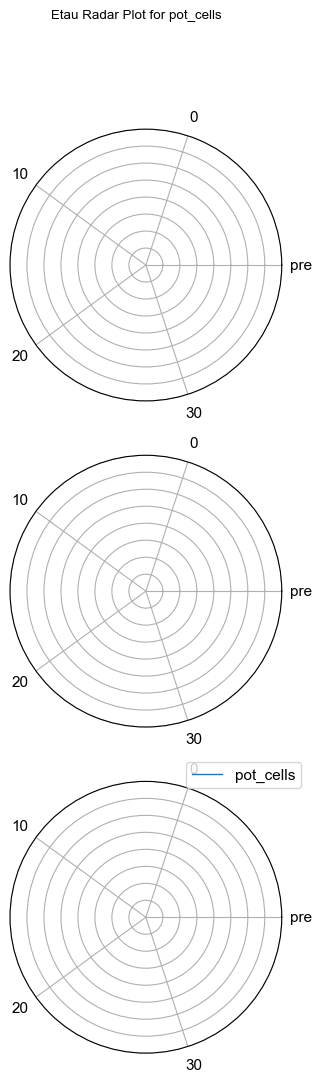

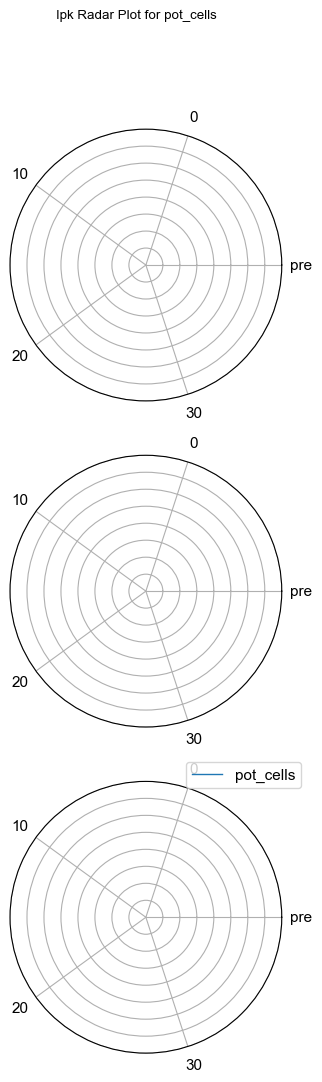

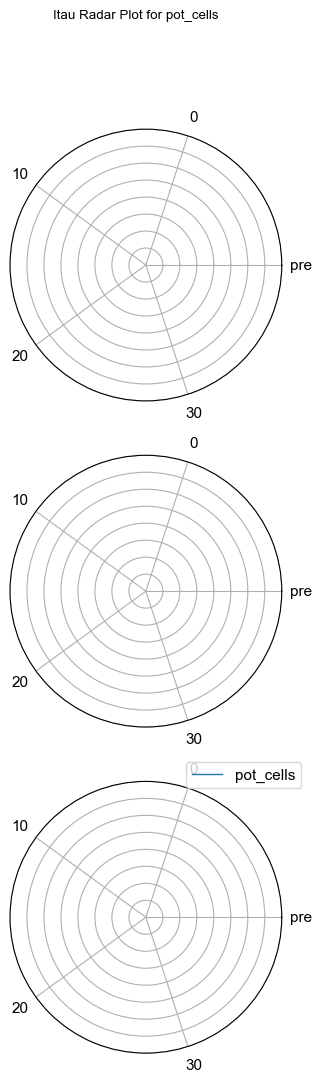

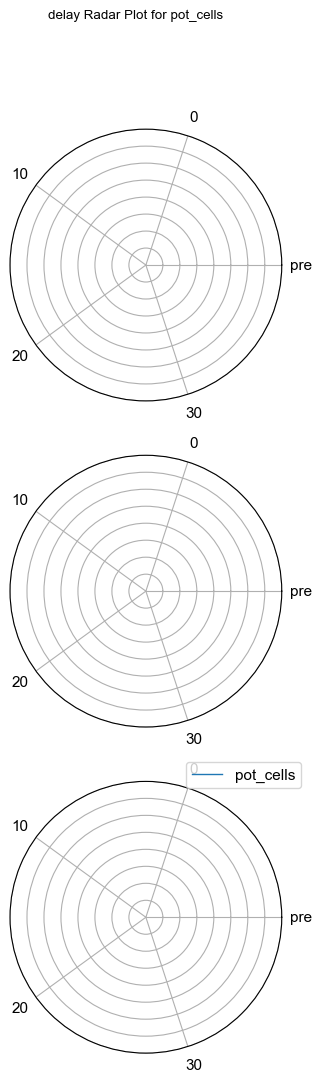

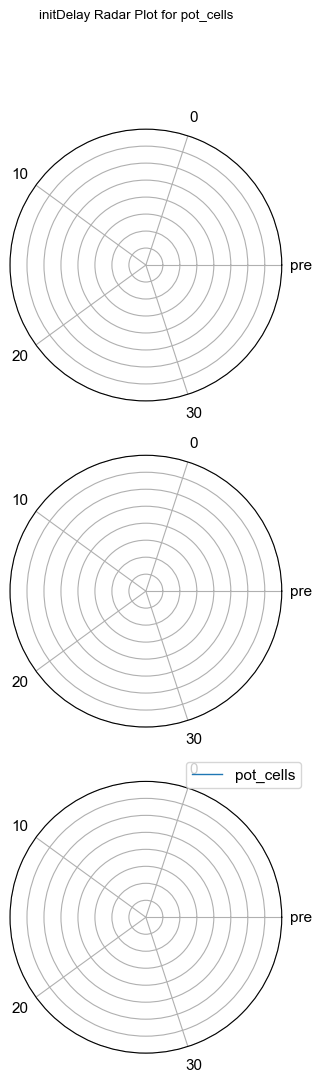

In [120]:
# Example usage with your data
curv_dat = curvfit_data[curvfit_data["cell_ID"].isin(learners)].reset_index(drop=True)
for feature in features:
    plot_cell_category_classified_EPSP_features(curv_dat, feature, "pot_cells")

In [466]:
all_cells_all_trails_extracted_featrues.head()#["frame_status"].unique()

cell_ID frame_status pre_post_status   frame_id  trial_no  \
0  2022_12_12_cell_5      pattern          post_0  pattern_0         0   
0  2022_12_12_cell_5      pattern          post_0  pattern_0         1   
0  2022_12_12_cell_5      pattern          post_0  pattern_0         2   
0  2022_12_12_cell_5      pattern          post_0  pattern_1         0   
0  2022_12_12_cell_5      pattern          post_0  pattern_1         1   

   min_trace  max_trace     abs_area     pos_area    neg_area  ...  \
0  -1.442230  12.818634  237031840.0  158334032.0  78697808.0  ...   
0  -1.769188  15.180275  290316480.0  199386208.0  90930264.0  ...   
0  -1.707489  16.053741  265094320.0  189985072.0  75109248.0  ...   
0  -1.494659  13.193451  238644880.0  161582928.0  77061928.0  ...   
0  -1.511871  12.623871  232197312.0  164338464.0  67858832.0  ...   

   max_field_t  min_field_t  \
0     0.013151      0.00255   
0     0.022652      0.00215   
0     0.010901      0.00230   
0     0.017502      0.00185   
0     0.013301      0.00190   

                                               trace  \
0  [-0.004852295, 0.0073547363, -0.007904053, -0....   
0  [0.01914215, -0.011375427, -0.026634216, -0.02...   
0  [-0.0046081543, -0.0046081543, -0.007659912, 0...   
0  [-0.023712158, -0.0206604, -0.023712158, -0.02...   
0  [-0.06838989, -0.053131104, -0.047027588, -0.0...   

                                               field  \
0  [0.040245056, 0.058555603, 0.07396698, 0.08419...   
0  [0.064323425, 0.049827576, 0.043876648, 0.0455...   
0  [0.06317139, 0.055847168, 0.03768921, 0.022735...   
0  [0.09341431, 0.09448242, 0.08425903, 0.0825805...   
0  [0.06252289, 0.048179626, 0.035362244, 0.05672...   

                                                 ttl   mean_rmp  mepsp_amp  \
0  [0.018310547, 0.018615723, 0.016479492, 1.5722... -63.685665   0.802338   
0  [0.018310547, 0.018615723, 0.016479492, 1.5722... -63.685665   0.928566   
0  [0.018310547, 0.018615723, 0.016479492, 1.5722... -63.685665   1.346303   
0  [0.018005371, 0.017089844, 0.018615723, 1.5701... -63.685665   1.039171   
0  [0.018005371, 0.017089844, 0.018615723, 1.5701... -63.685665        NaN   

                                          mepsp_time  num_mepsp freq_mepsp  
0  [727.559094488681, 937.4617182714784, 1043.413...          6       1.50  
0  [350.55438192977414, 2252.178152226903, 3650.8...          3       0.75  
0  [807.8100976262203, 2031.5753946924335, 2287.3...          3       0.75  
0  [215.85269815872698, 566.707083838548, 710.508...          7       1.75  
0                                                 []          0       0.00  

[5 rows x 27 columns]

In [165]:
pre_post_grp = all_cells_all_trails_extracted_featrues.groupby(by="pre_post_status")
mepsp_pre=[]
mepsp_post=[]
for pps,pps_data in pre_post_grp:
    if pps=="pre":
        mepsp_pre.append(pps_data)
    elif pps=="post_3":
        mepsp_post.append(pps_data)
    else:
        pass

In [167]:
mepsp_pre = pd.concat(mepsp_pre)
mepsp_post = pd.concat(mepsp_post)

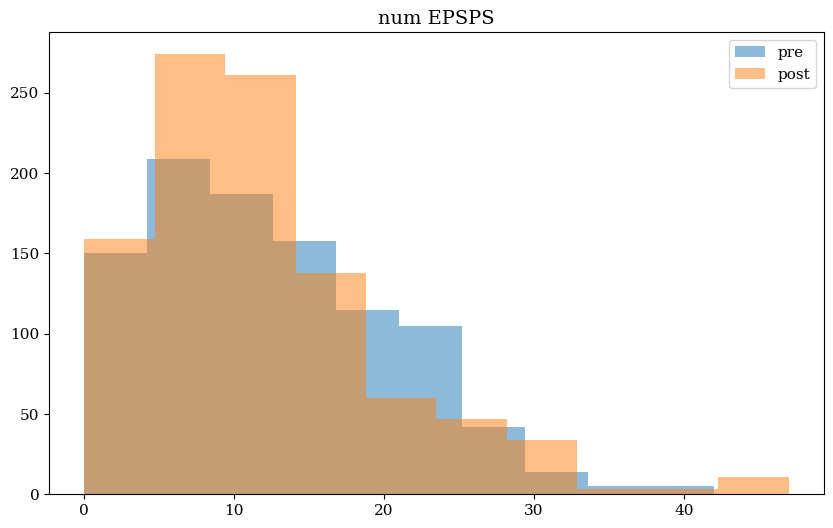

In [389]:
mepsp_pre["num_mepsp"].hist(grid=False,alpha=0.5, label="pre")
mepsp_post["num_mepsp"].hist(grid=False,alpha=0.5, label="post")
plt.title("num EPSPS")
plt.legend()

Text(0.5, 1.0, 'freq EPSPS')

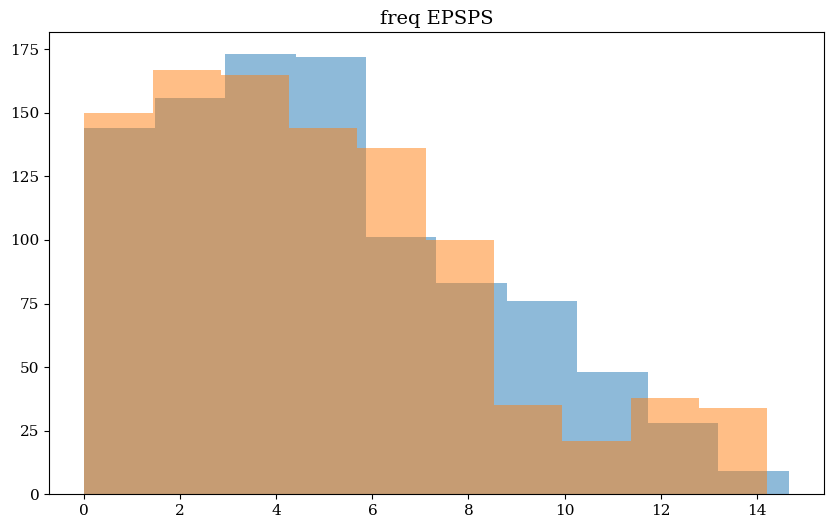

In [387]:
mepsp_pre["freq_mepsp"].hist(grid=False,alpha=0.5, label="pre")
mepsp_post["freq_mepsp"].hist(grid=False,alpha=0.5, label="pre")
plt.title("freq EPSPS")

<Axes: xlabel='pre_post_status', ylabel='freq_mepsp'>

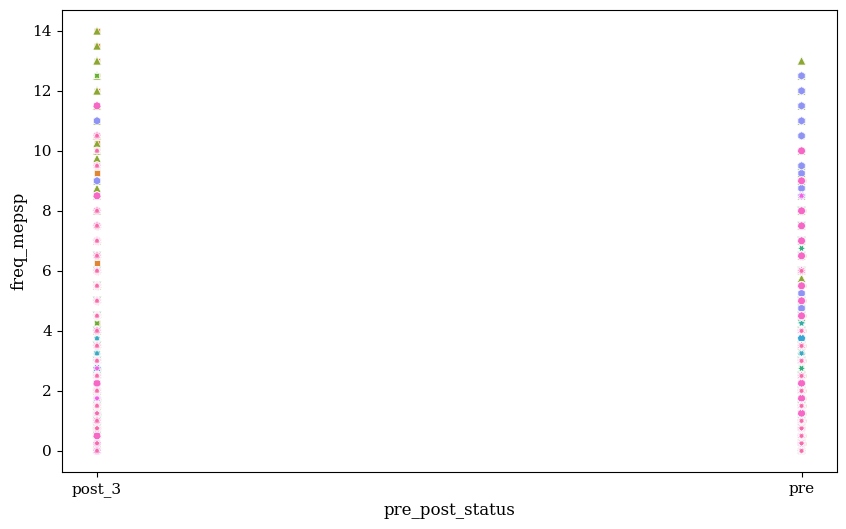

In [390]:
pre_post_dat = all_cells_all_trails_extracted_featrues[all_cells_all_trails_extracted_featrues["pre_post_status"].isin(["pre","post_3"])].reset_index(drop=True)
sns.scatterplot(data=pre_post_dat, x="pre_post_status", y="freq_mepsp", hue="cell_ID",legend=False,style="cell_ID")

(-0.1256011962890625, 5.0)

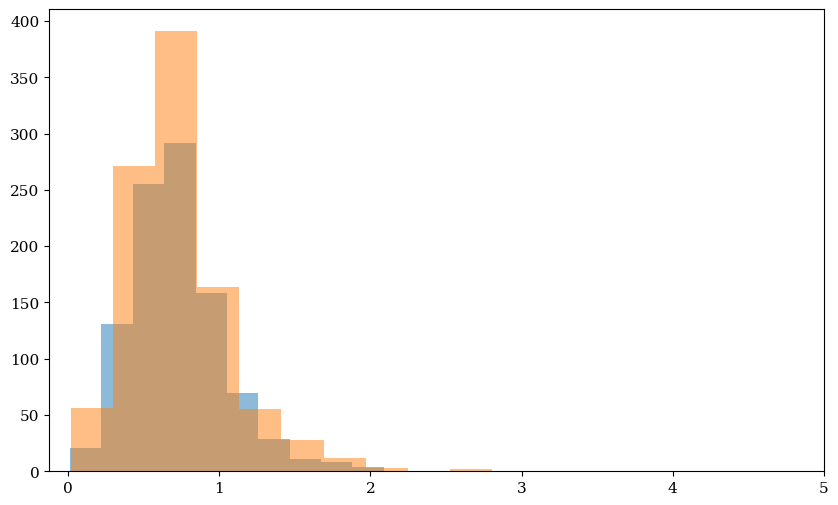

In [392]:
pre_post_dat[pre_post_dat["pre_post_status"]=="pre"]["mepsp_amp"].hist(grid=False,alpha=0.5)
pre_post_dat[pre_post_dat["pre_post_status"]=="post_3"]["mepsp_amp"].hist(grid=False, alpha=0.5)
plt.xlim(None,5)

In [142]:
learners = cell_dict_classified["ap_cells"]["cell_ID"].unique()
non_learners = cell_dict_classified["an_cells"]["cell_ID"].unique()

NameError: name 'cell_dict_classified' is not defined

In [ ]:
2023_01_27_cell_2

In [458]:

def mepsp_distribution_plot(all_cell_df,field_to_plot, learners,non_learners):
    all_cell_df = all_cell_df[all_cell_df["pre_post_status"].isin(["pre","post_3"])]
    cell_grps=all_cell_df.groupby(by="cell_ID")
    for cell,cell_data in cell_grps:
        fig,axs=plt.subplots(3,1)
        if cell in learners:
            cell_type ="learner"
        elif cell in non_learners:
            cell_type ="non-learner"
        else:
            color="k"
            continue
            
        pps_grp = cell_data.groupby(by="pre_post_status")
        for pps, pps_data in pps_grp:
            if pps=="pre":
                color='r'
            elif pps=="post_3":
                color='b'
            else:
                continue
            pps_data= pps_data.reset_index(drop=True)
            sns.histplot(pps_data[field_to_plot], bins=20, kde=True, color=color, edgecolor='black', ax=axs[0],alpha=0.6, label=pps)
            sns.histplot(data= pps_data, x="mepsp_amp", bins=10, kde=True, color=color, edgecolor='black', ax=axs[1],alpha=0.6, label=pps)
            sns.histplot(data= pps_data, x="num_mepsp", bins=10, kde=True, color=color, edgecolor='black', ax=axs[2],alpha=0.6, label=pps)
        axs[0].set_title(f"{field_to_plot}:{cell_type}:{cell}")
        axs[1].set_title(f"mepsp amplitude:{cell_type}:{cell}")
        axs[2].set_title(f"mepsp number:{cell_type}:{cell}")
        axs[0].set_xlim(0,15)
        axs[1].set_xlim(0,3)
        axs[2].set_xlim(0,40)
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.close()
    

In [459]:
all_cells_all_trails_extracted_featrues.columns

Index(['cell_ID', 'frame_status', 'pre_post_status', 'frame_id', 'trial_no',
       'min_trace', 'max_trace', 'abs_area', 'pos_area', 'neg_area',
       'onset_time', 'max_field', 'min_field', 'slope', 'intercept',
       'min_trace_t', 'max_trace_t', 'max_field_t', 'min_field_t', 'trace',
       'field', 'ttl', 'mean_rmp', 'mepsp_amp', 'mepsp_time', 'num_mepsp',
       'freq_mepsp'],
      dtype='object')

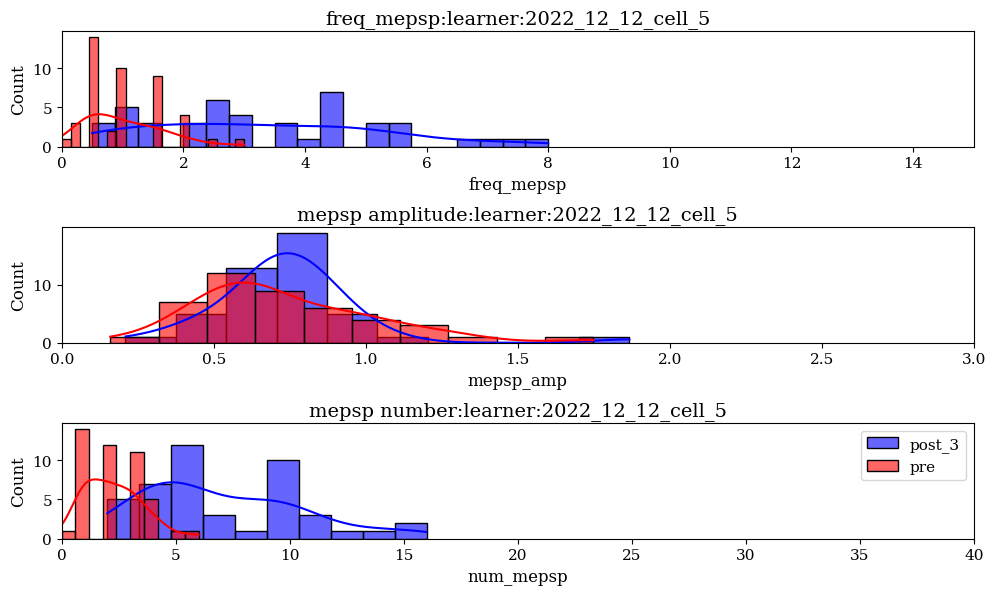

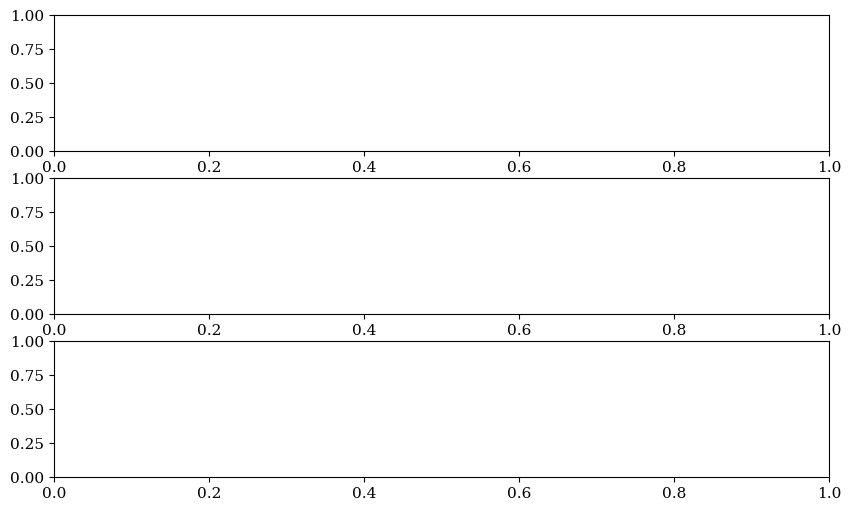

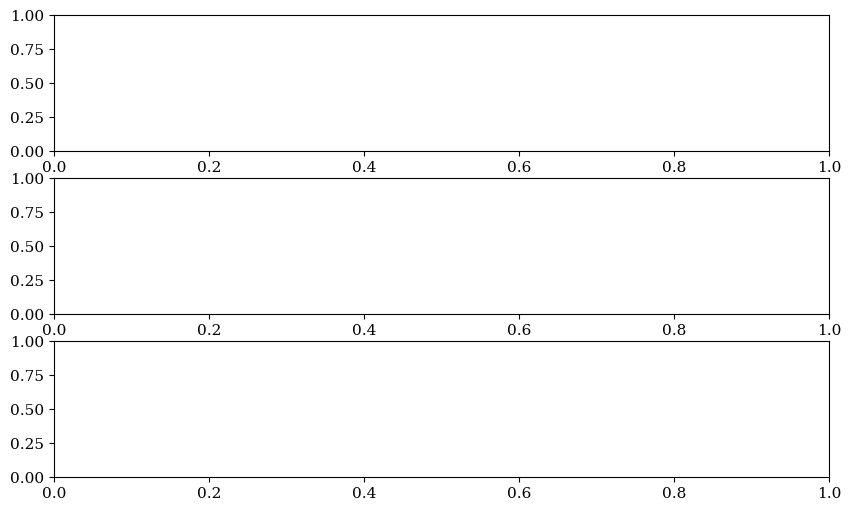

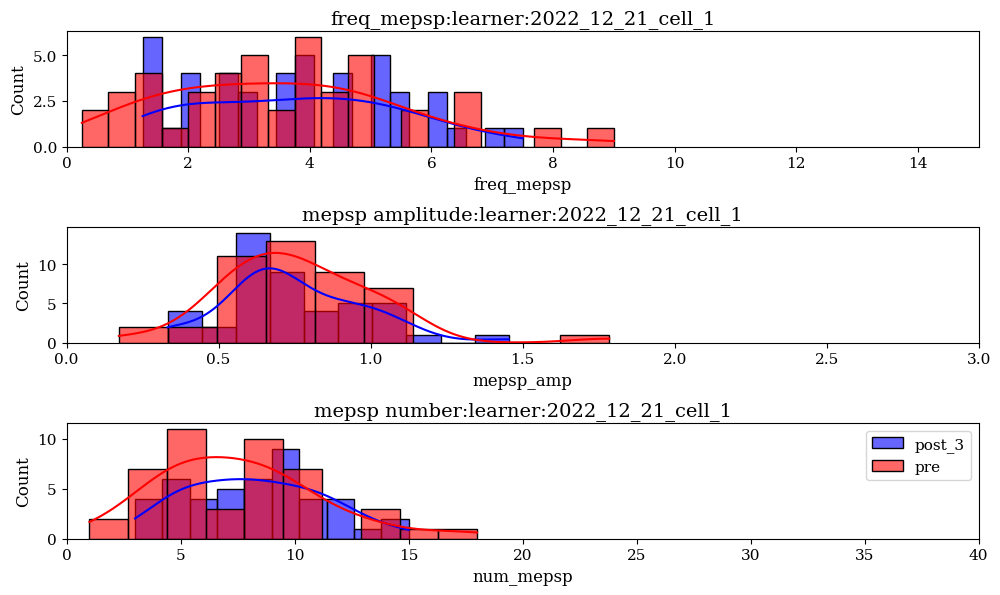

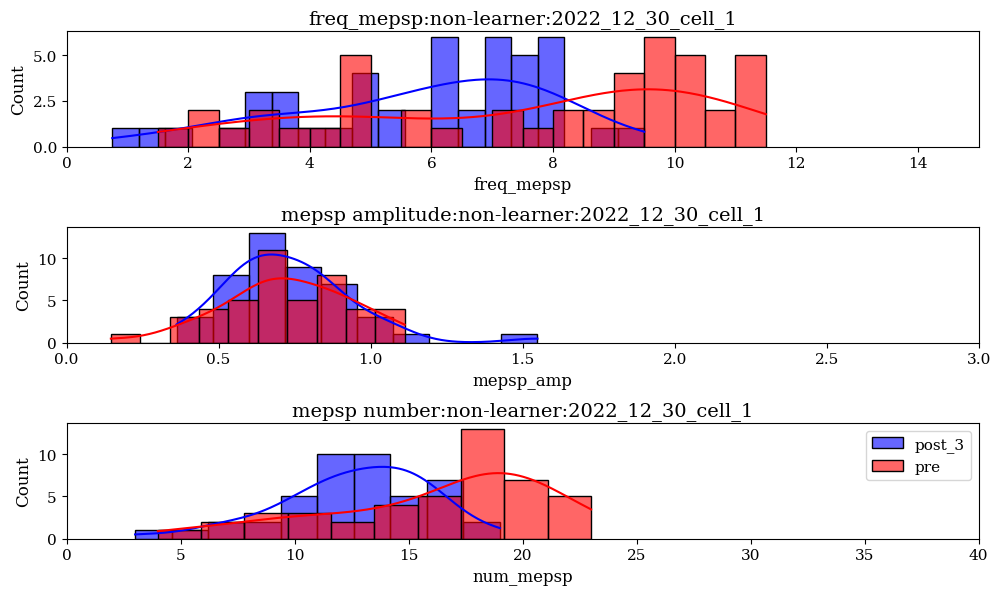

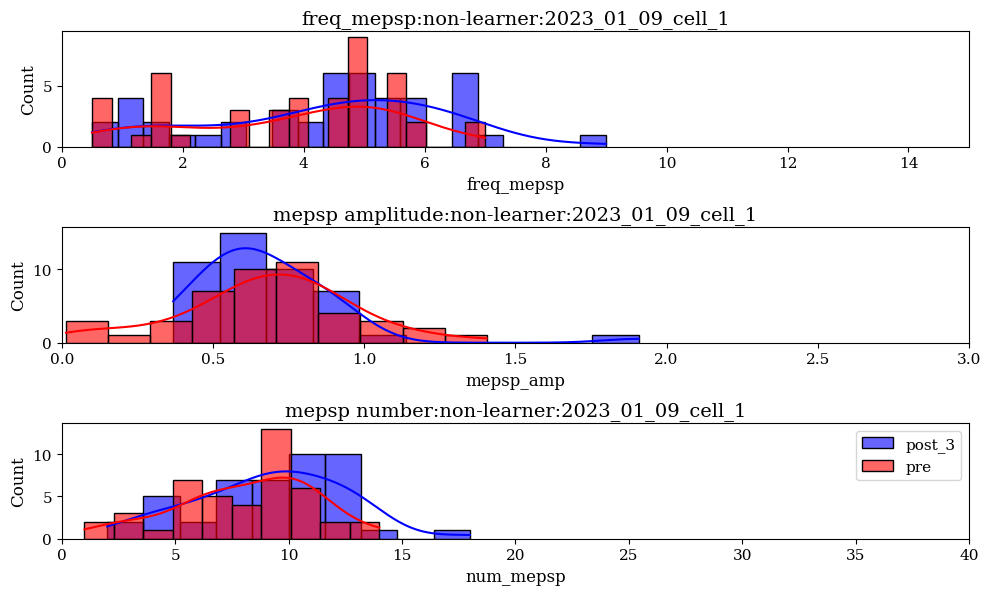

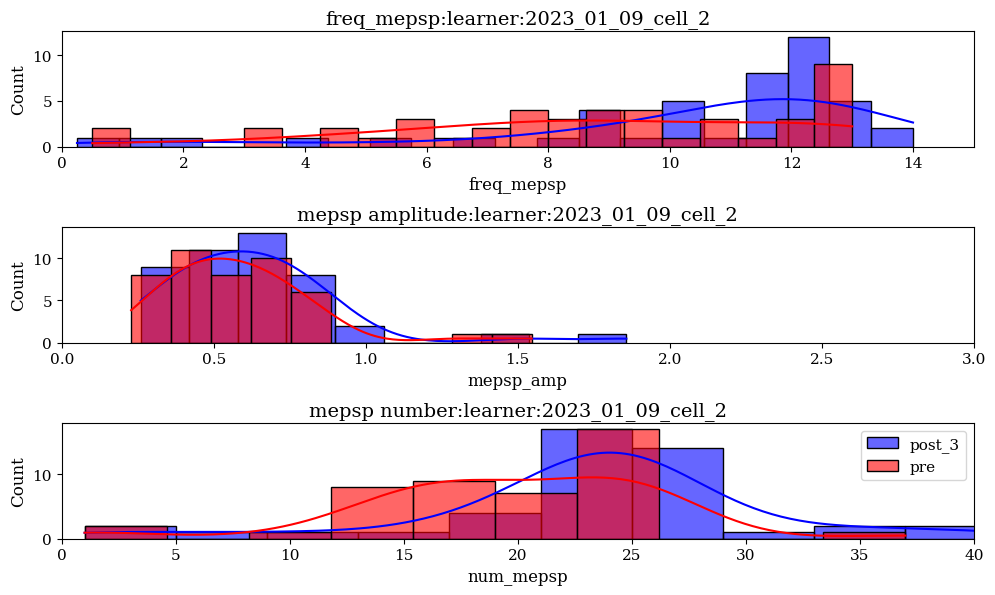

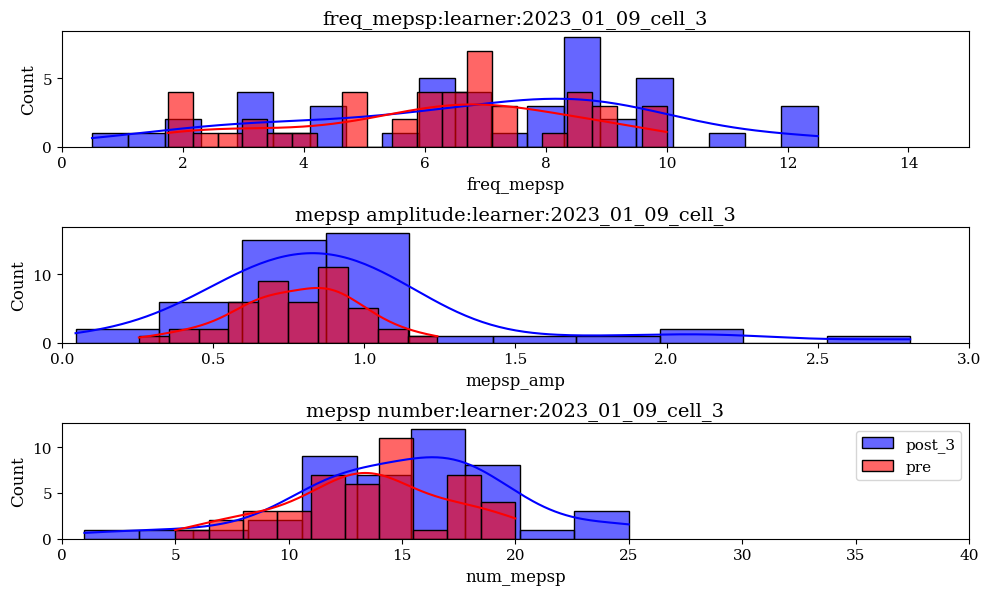

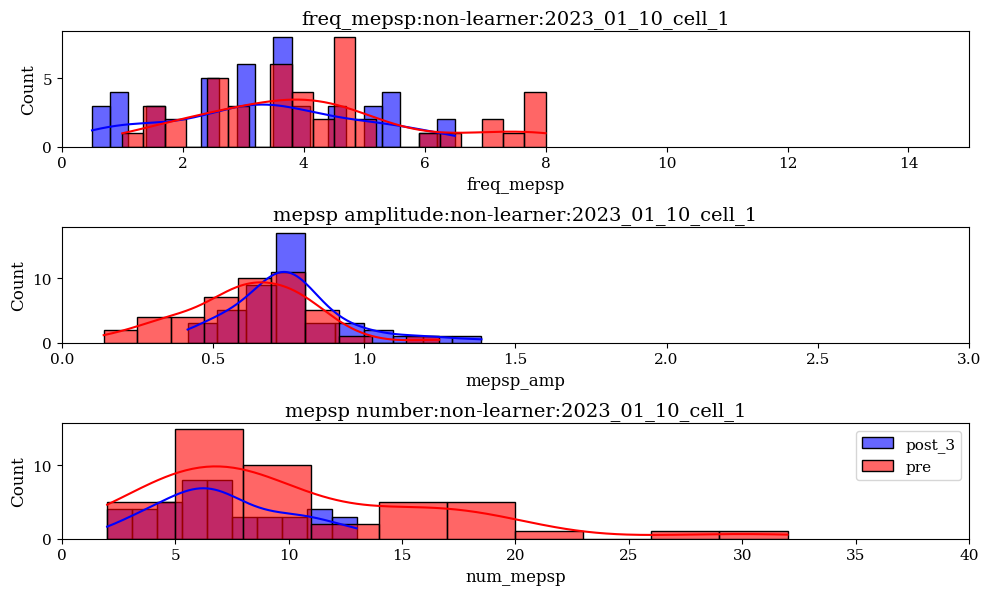

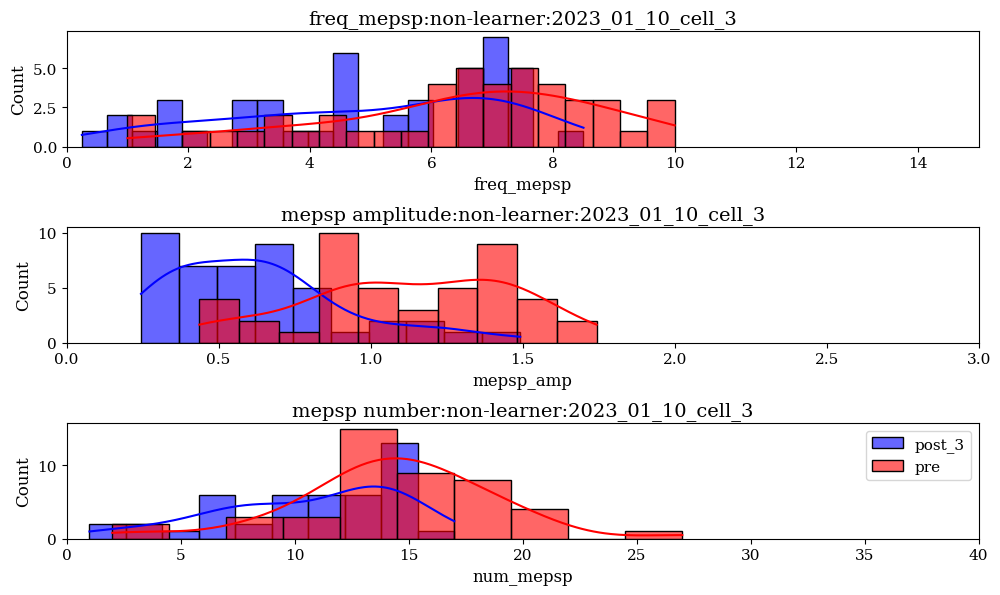

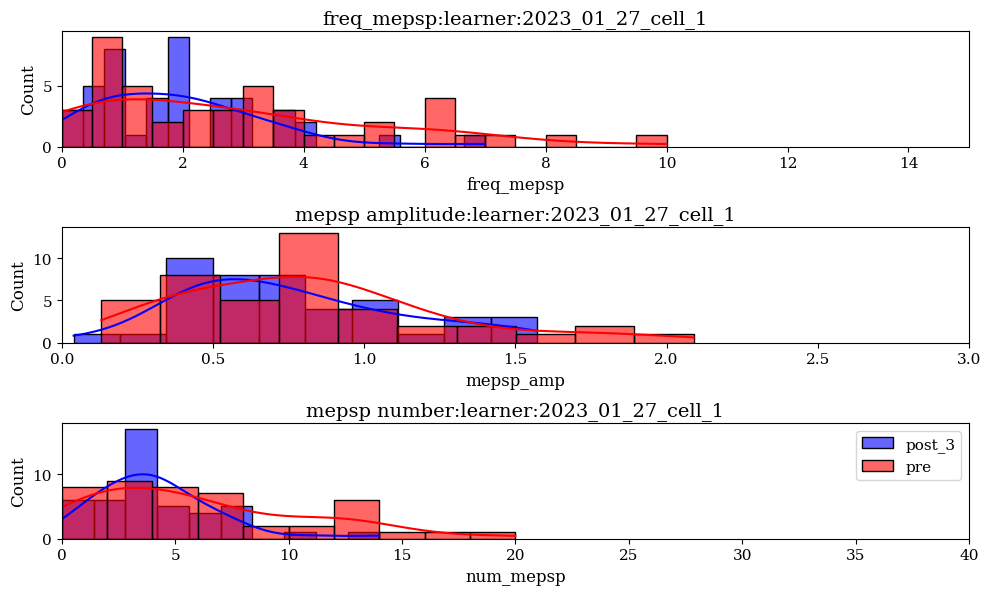

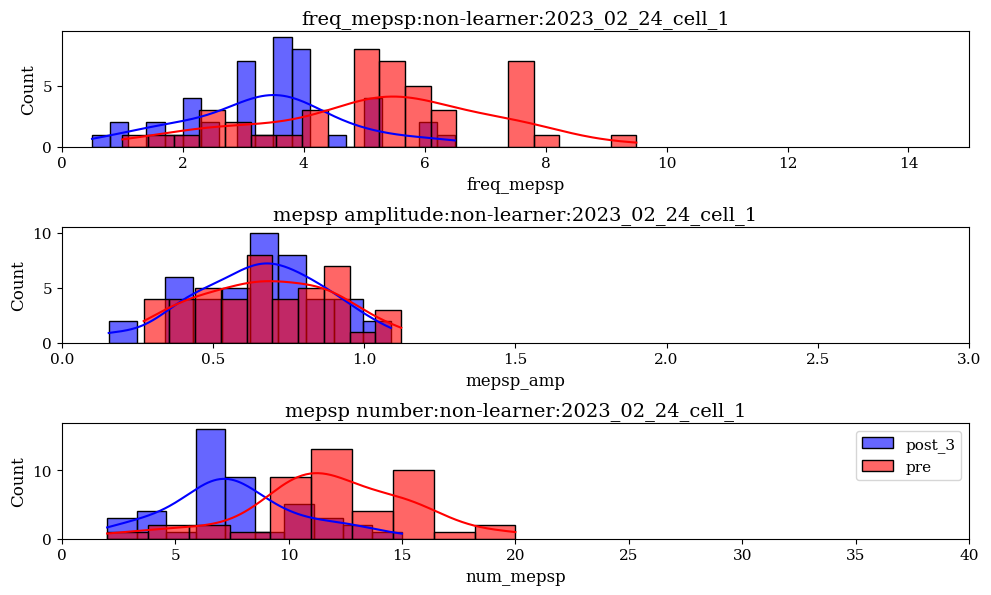

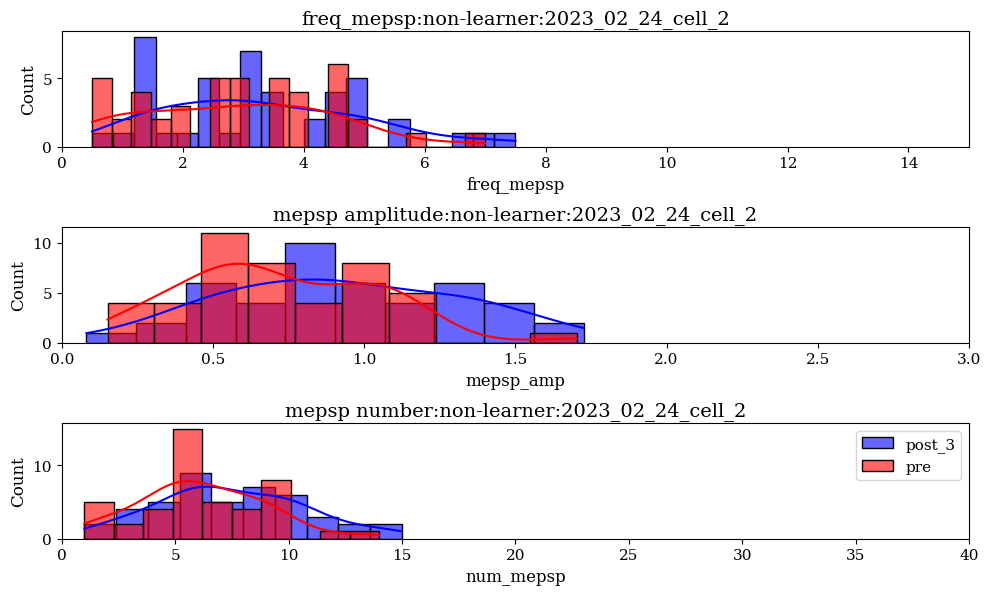

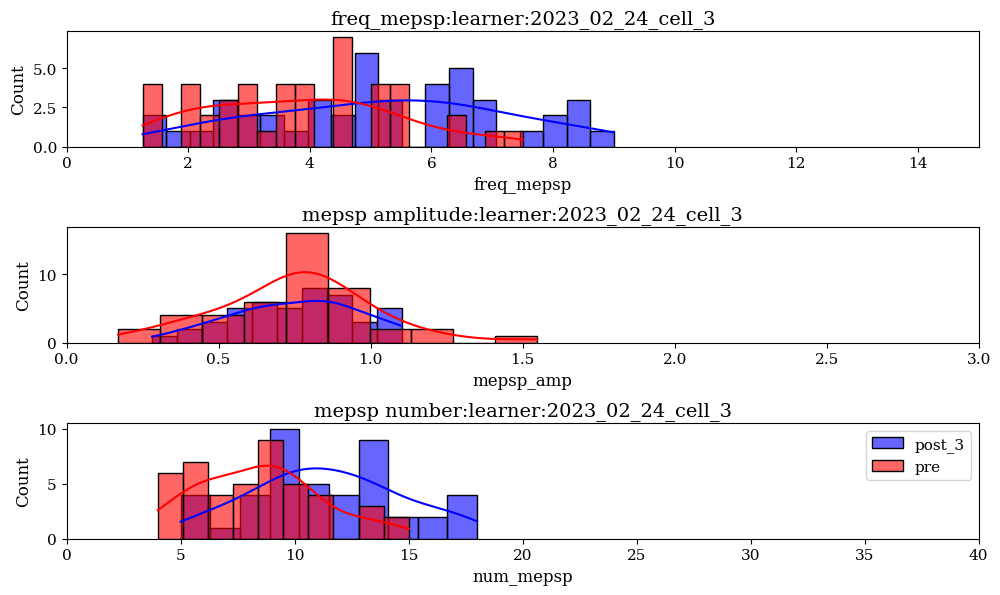

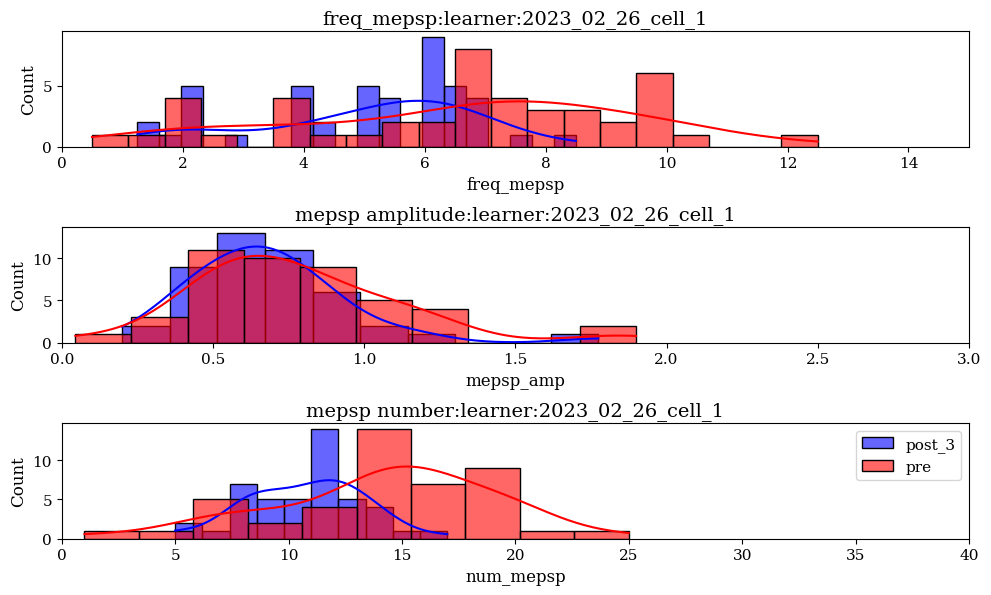

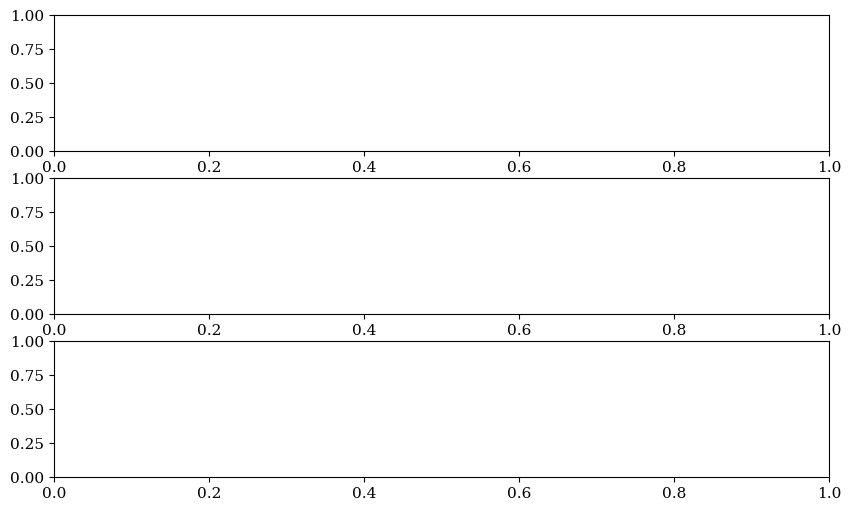

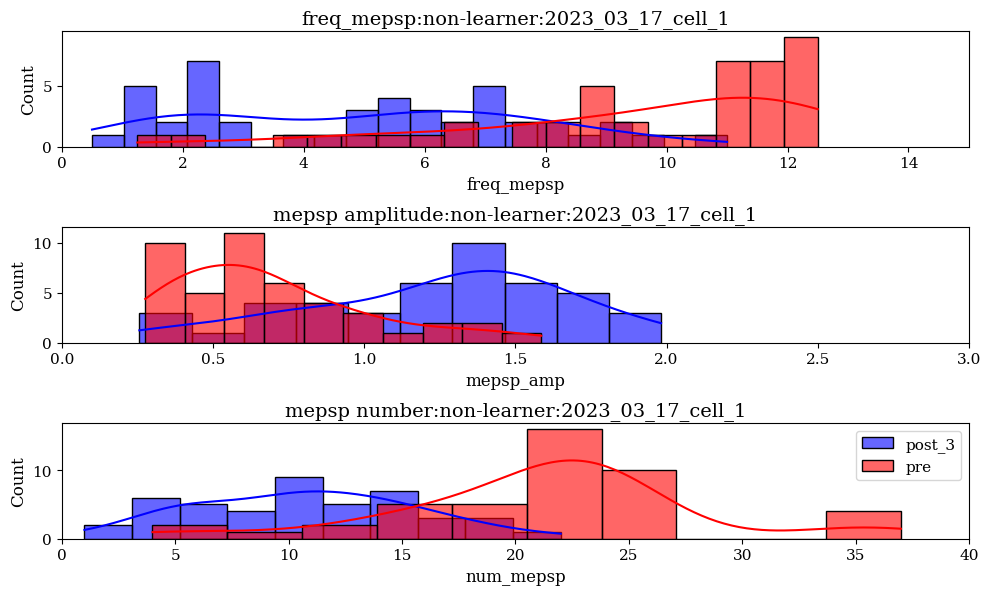

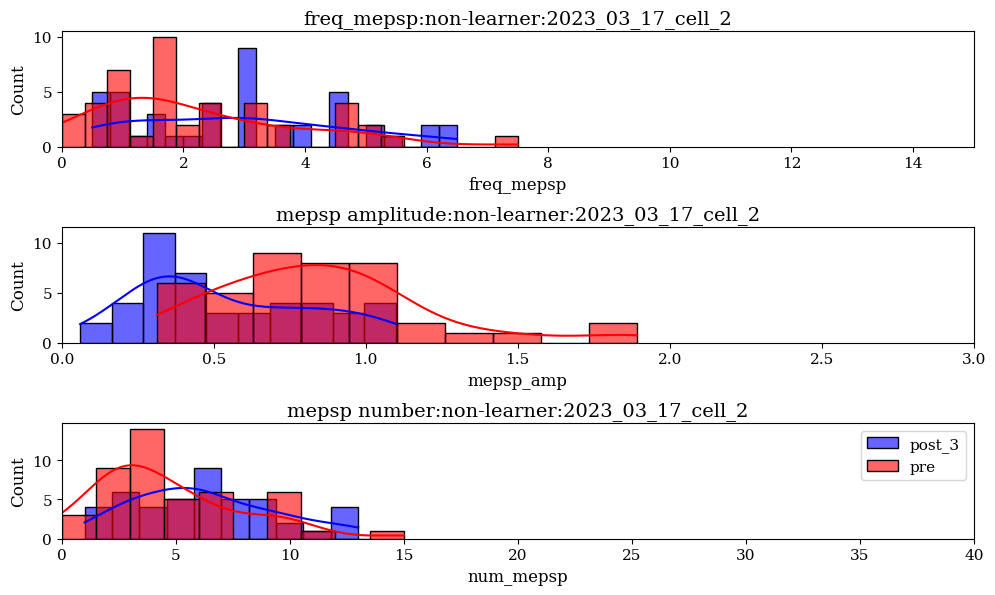

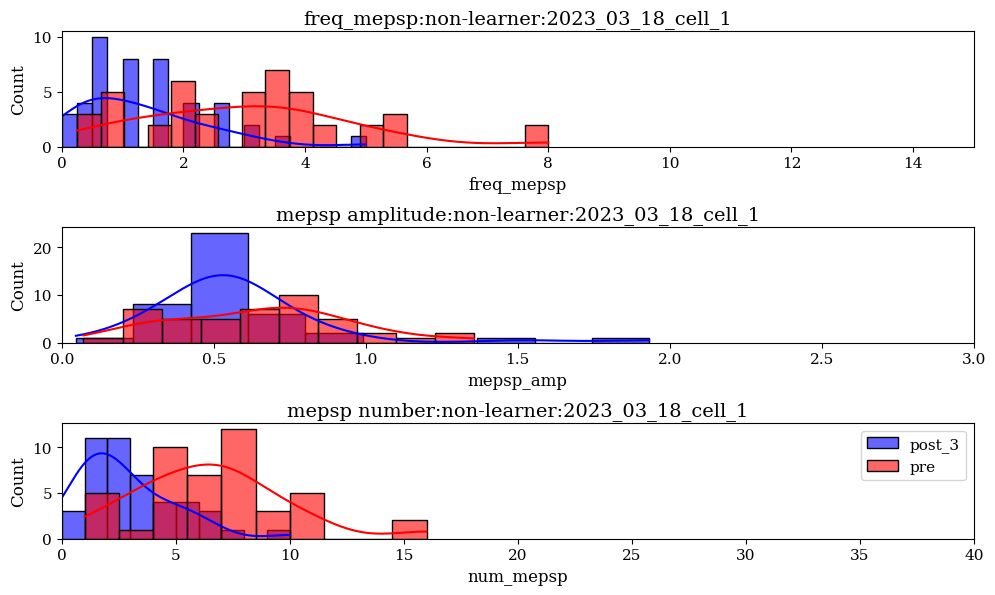

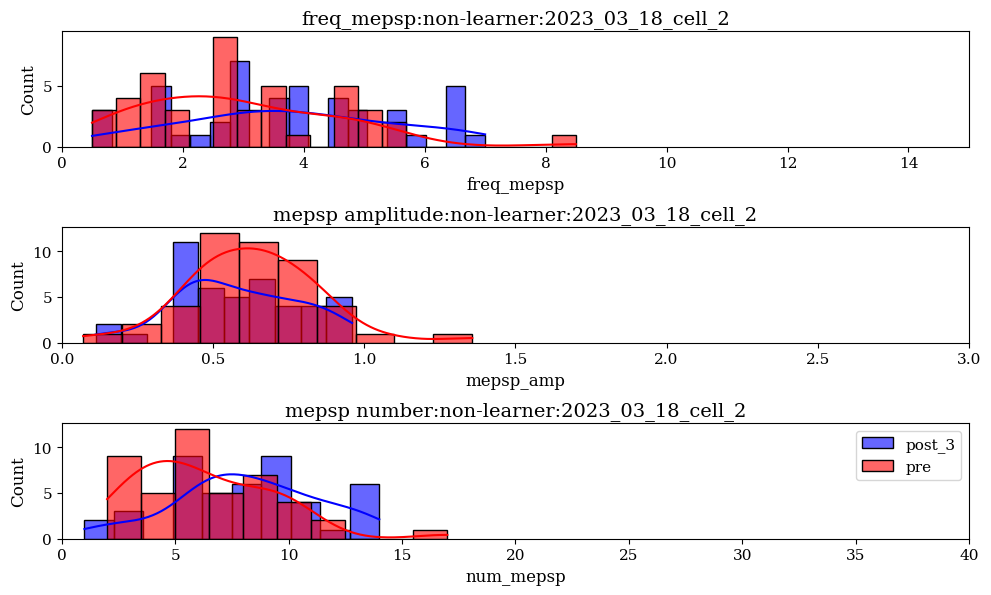

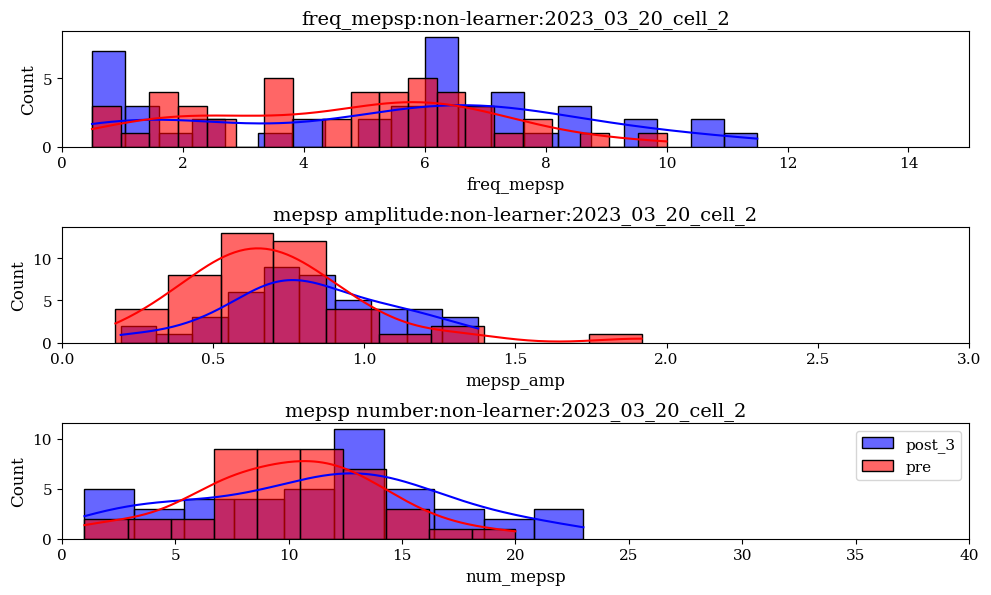

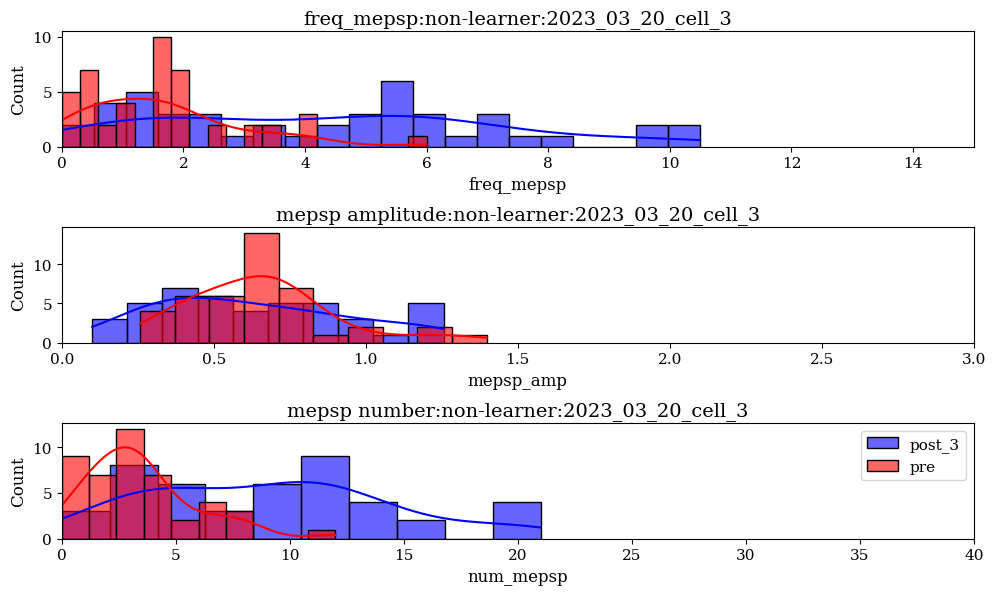

In [460]:
mepsp_distribution_plot(all_cells_all_trails_extracted_featrues,"freq_mepsp",learners,non_learners)

In [332]:
curve_fit_data = pd.read_hdf("/Users/anzalks/Documents/pattern_learning_paper/plotting_scripts/python_scripts_paper_ready/analysis_scripts/pickle_files_from_analysis/curvefir_results.h5")

In [134]:
curve_fit_data.columns

Index(['cell_ID', 'pre_post_status', 'frame_type', 'Epk', 'Etau', 'Ipk',
       'Itau', 'delay', 'initDelay', 'score'],
      dtype='object')

In [143]:
cell_dict_classified = pd.read_pickle("/Users/anzalks/Documents/pattern_learning_paper/plotting_scripts/python_scripts_paper_ready/analysis_scripts/pickle_files_from_analysis/all_cells_fnorm_classifeied_dict.pickle")

In [246]:
learners = cell_dict_classified["ap_cells"]["cell_ID"].unique()
non_learners = cell_dict_classified["an_cells"]["cell_ID"].unique()

In [136]:
def norm_values(cell_list,val_to_plot):
    cell_list = cell_list.copy()
    #print(f"cell list inside func : {cell_list}")
    cell_grp=cell_list.groupby(by="cell_ID")
    for c, cell in cell_grp:
        pat_grp = cell.groupby(by="frame_type")
        for p,pat in pat_grp:
            if "pattern" not in p:
                continue
            else:
                #print(f"c:{c}, p:{p}")
                pre_val= float(cell[(cell["cell_ID"]==c)&(cell["frame_type"]==p)&(cell["pre_post_status"]=="pre")][val_to_plot])
                pp_grp = pat.groupby(by="pre_post_status")
                for pr, pp in pp_grp:
                    norm_val = float(cell[(cell["cell_ID"]==c)&(cell["frame_type"]==p)&(cell["pre_post_status"]==pr)][val_to_plot])
                    norm_val = (norm_val/pre_val)*100
                    cell_list.loc[(cell_list["cell_ID"]==c)&(cell_list["frame_type"]==p)&(cell_list["pre_post_status"]==pr),val_to_plot]=norm_val
    return cell_list
   
def plot_cell_dist(catcell_dist,val_to_plot,fig,axs,pattern_number,y_lim,
                   x_label, cell_type,plt_color,resp_color):
    pat_num=int(pattern_number.split("_")[-1])
    num_cells= len(catcell_dist["cell_ID"].unique())
    pfd = catcell_dist.groupby(by="frame_type")
    for c, pat in pfd:
        pat[f"{val_to_plot}"].where(pat[f"{val_to_plot}"] <1000, np.nan, inplace=True)
        if c != pattern_number:
            continue
        else:
            order = np.array(('pre','post_0','post_1','post_2','post_3'),dtype=object)
            g=sns.stripplot(data=pat, x="pre_post_status",y=f"{val_to_plot}",
                            order=order,ax=axs,color=resp_color,
                            alpha=0.6,size=8, label='cell response')#alpha=0.8,
            sns.pointplot(data=pat, x="pre_post_status",y=f"{val_to_plot}",
                          errorbar="se",order=order,capsize=0.08,ax=axs,
                          color=plt_color, linestyles='dotted',scale = 0.8,
                         label="average cell response")
            g.set_title(None)
            #"""
            pvalList = []
            anotp_list = []
            for i in order[1:]:
                posti ="post{i}"
                #non parametric, paired and small sample size, hence used Wilcoxon signed-rank test
                #Wilcoxon signed-rank test
                posti= spst.wilcoxon(pat[pat["pre_post_status"]=='pre'][f"{val_to_plot}"],pat[pat["pre_post_status"]==i][f"{val_to_plot}"],
                                     zero_method="wilcox", correction=True)
                pvalList.append(posti.pvalue)
                anotp_list.append(("pre",i))
            annotator = Annotator(axs,anotp_list,data=pat, 
                                  x="pre_post_status",
                                  y=f"{val_to_plot}",
                                  order=order,
                                 fontsize=8)
            #annotator = Annotator(axs[pat_num],[("pre","post_0"),("pre","post_1"),("pre","post_2"),("pre","post_3")],data=cell, x="pre_post_status",y=f"{col_pl}")
            annotator.set_custom_annotations([bpf.convert_pvalue_to_asterisks(a) for a in pvalList])
            annotator.annotate()
            #"""
            axs.axhline(100, ls=':',color="k", alpha=0.4)
            if pat_num==0:
                sns.despine(fig=None, ax=axs, top=True, right=True, 
                            left=False, bottom=False, offset=None, trim=False)
                axs.set_ylabel("% change in\nEPSP amplitude")
                axs.set_xlabel(None)
                #axs[pat_num].set_yticks([])
            elif pat_num==1:
                sns.despine(fig=None, ax=axs, top=True, right=True, 
                            left=False, bottom=False, offset=None, trim=False)
                axs.set_ylabel(None)
                axs.set_yticklabels([])
                if cell_type=="dep_cells":
                    axs.set_xlabel(x_label)
                else:
                    axs.set_xlabel(None)
            elif pat_num==2:
                sns.despine(fig=None, ax=axs, top=True, right=True, 
                            left=False, bottom=False, offset=None, trim=False)
                axs.set_xlabel(None)
                axs.set_ylabel(None)
                axs.set_yticklabels([])
            else:
                pass 
            g.set(ylim=y_lim)
            g.set_xticklabels(time_points,rotation=0)
            g.legend_.remove()
            if cell_type!="dep_cells":
                axs.set_xticklabels([])
            else:
                pass 


    ax_pos = axs.get_position()
    #new_ax_pos = [ax_pos.x0-0.02, ax_pos.y0, ax_pos.width,
    #              ax_pos.height]
    #axs.set_position(new_ax_pos)




def plot_cell_category_classified_EPSP_features(esp_feat_cells_df,val_to_plot,
                                                fig,axs1,axs2,axs3,cell_type):
    cell_df= norm_values(esp_feat_cells_df,val_to_plot)
    if cell_type=="pot_cells":
        strp_color = bpf.CB_color_cycle[0]
        line_color = bpf.CB_color_cycle[5]
        y_lim = (-100,800)
        x_label = None
    elif cell_type=="dep_cells":
        strp_color = bpf.CB_color_cycle[1]
        line_color = bpf.CB_color_cycle[5]
        y_lim = (-200,500)
        x_label = "time points (mins)"
    else:
        y_lim=None
        strp_color = bpf.CB_color_cycle[1]
        line_color = bpf.CB_color_cycle[5]
        x_label = "time points (mins)"
        print("uncagerised cell")
        
    plot_cell_dist(cell_df,val_to_plot,fig,axs1,"pattern_0",
                   y_lim,x_label,cell_type,line_color,strp_color
                  )
    plot_cell_dist(cell_df,val_to_plot,fig,axs2,"pattern_1",
                   y_lim,x_label,cell_type,line_color,strp_color
                  )
    plot_cell_dist(cell_df,val_to_plot,fig,axs3,"pattern_2",
                   y_lim,x_label,cell_type,line_color,strp_color
                  )

In [119]:
def classify_cells_curve_fit(cell_dict_classified,curve_fit_data):
    cell_grps =curve_fit_data.groupby(by="cell_ID")
    learners_list = cell_dict_classified["ap_cells"]["cell_ID"].unique()
    non_learners_list = cell_dict_classified["an_cells"]["cell_ID"].unique()
    #print(non_learners_list)
    learners=[]
    non_learners =[]
    for cell, cell_data in cell_grps:
        if cell in learners_list:
            cell_data["cell_ID"]=cell
            learners.append(cell_data)
            #print("learner", cell)
        elif cell in non_learners_list:
            cell_data["cell_ID"]=cell
            non_learners.append(cell_data)
            #print("non-learner", cell)
        else:
            pass
            #print("uncategorised")
    learners=pd.concat(learners)
    non_learners = pd.concat(non_learners)
    return learners, non_learners
    

In [550]:
learners,non_learners = classify_cells_curve_fit(cell_dict_classified,curve_fit_data)

In [558]:
learners["cell_ID"].unique()

array(['2022_12_12_cell_5', '2022_12_21_cell_1', '2023_01_09_cell_2',
       '2023_01_09_cell_3', '2023_01_27_cell_1', '2023_02_24_cell_3',
       '2023_02_26_cell_1'], dtype=object)

In [140]:
def plot_feature_from_curve_fit(feature_to_plot):
    learners,non_learners = classify_cells_curve_fit(cell_dict_classified,curve_fit_data)
    fig = plt.figure()
    #plot patterns
    axs1 = fig.add_subplot(131)
    axs2 = fig.add_subplot(132)
    axs3 = fig.add_subplot(133)

    plot_cell_category_classified_EPSP_features(learners,feature_to_plot,fig,axs1,axs2,axs3,"pot_cells")

    axs2.set_title(f"learners: {feature_to_plot}")
    plt.show()
    plt.close(fig)
    
    fig = plt.figure()
    #plot patterns
    axs1 = fig.add_subplot(131)
    axs2 = fig.add_subplot(132)
    axs3 = fig.add_subplot(133)
    
    plot_cell_category_classified_EPSP_features(non_learners,feature_to_plot,fig,axs1,axs2,axs3,"dep_cells")
    
    axs2.set_title(f"non-learners: {feature_to_plot}")
    plt.show()
    plt.close(fig)


In [151]:
features_to_plot = list(curve_fit_data.columns)[3:-1]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: *
pre vs. post_1: *
pre vs. post_2: *
pre vs. post_3: *
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: *
pre vs. post_1: ns
pre vs. post_2: *
pre vs. post_3: *
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns


/Users/anzalks/miniconda3/envs/lab_env/lib/python3.10/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


pre vs. post_2: ns
pre vs. post_3: ns


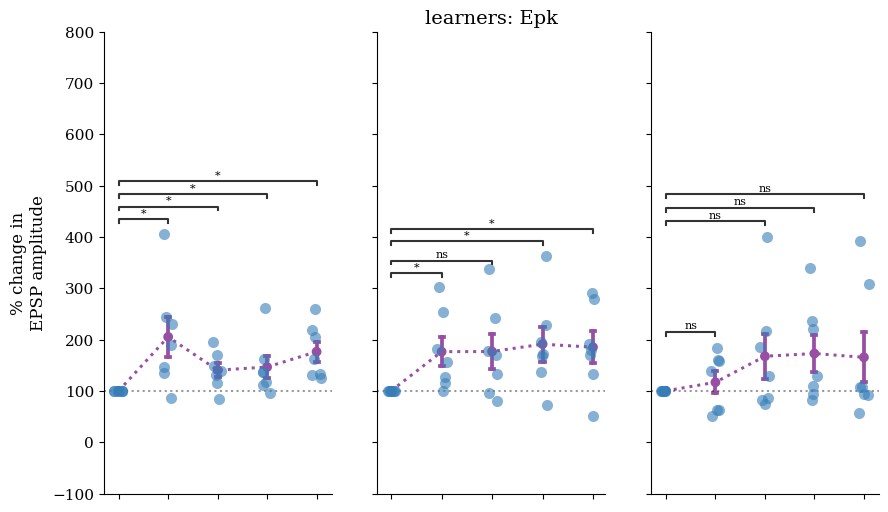

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: **
pre vs. post_3: ***
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: *
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns


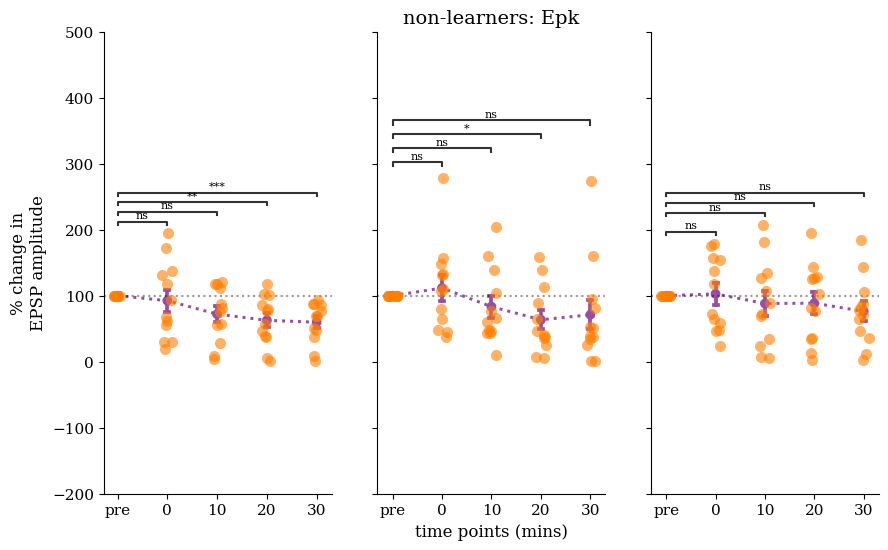

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: *
pre vs. post_1: ns
pre vs. post_2: *
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns


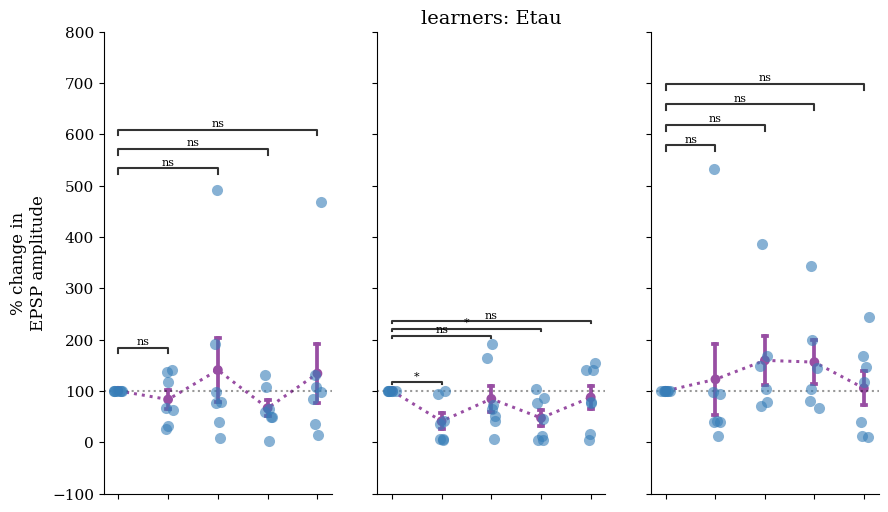

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: *
pre vs. post_3: **
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: *
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns


/Users/anzalks/miniconda3/envs/lab_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns


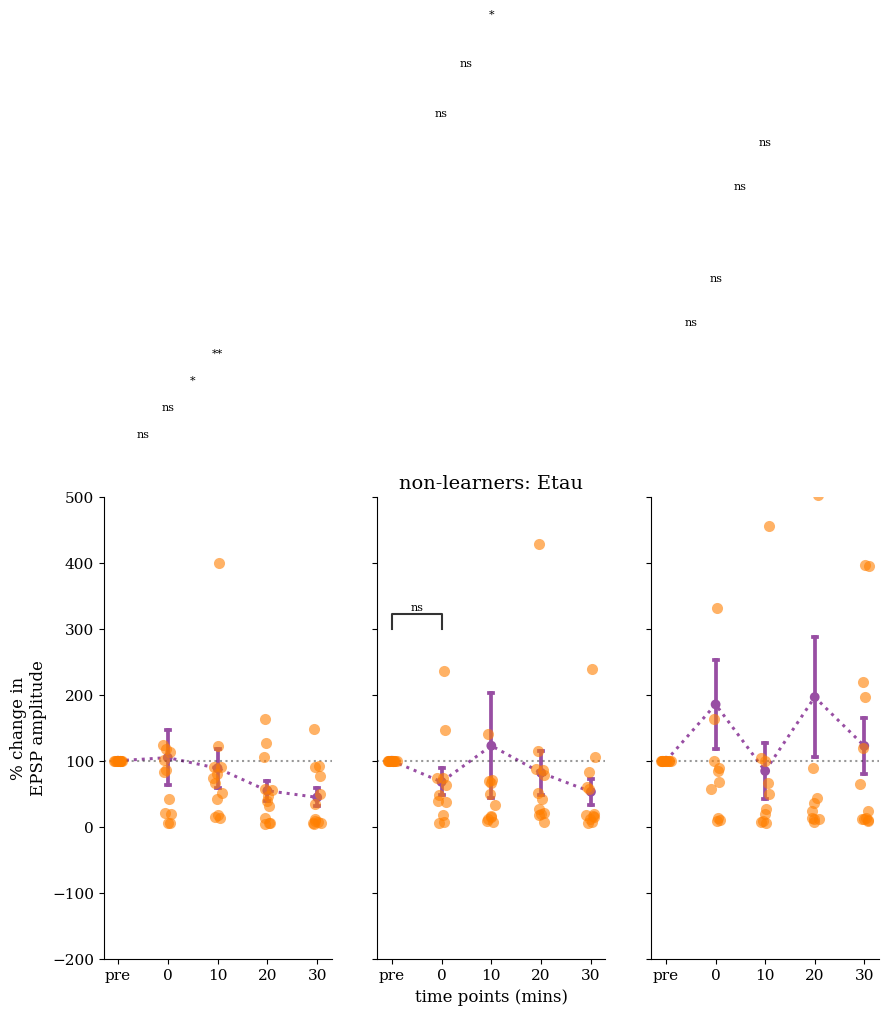

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: *
pre vs. post_2: *
pre vs. post_3: *


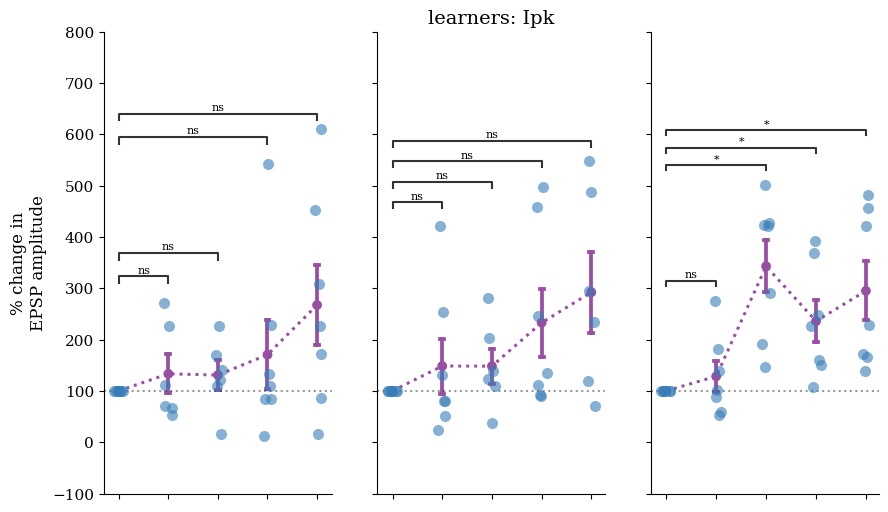

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: *
pre vs. post_3: *


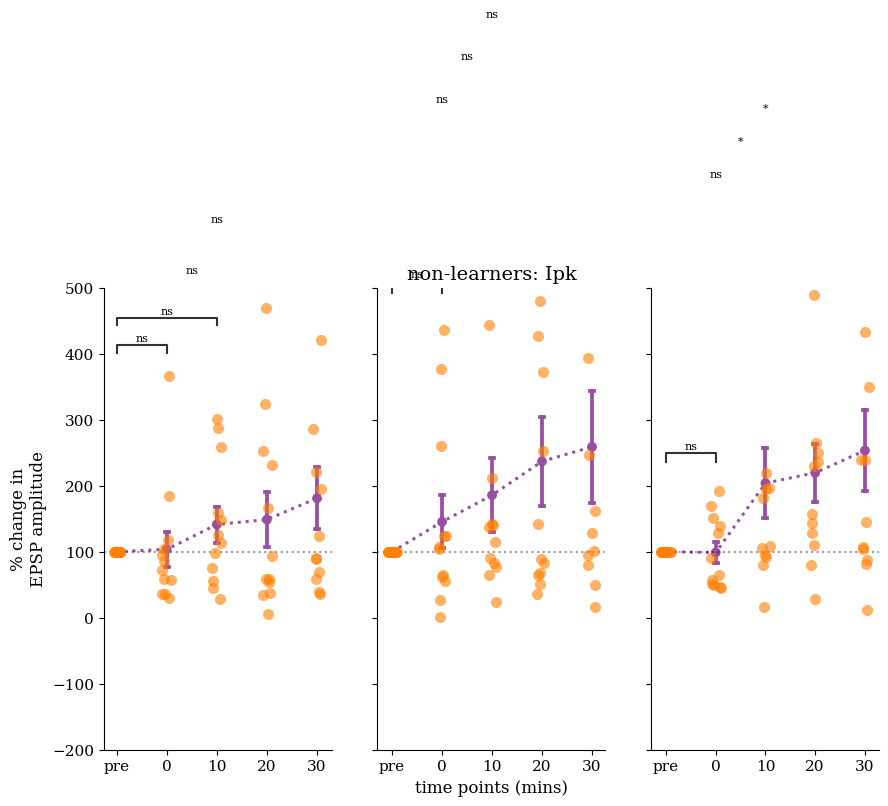

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: *
pre vs. post_3: ns


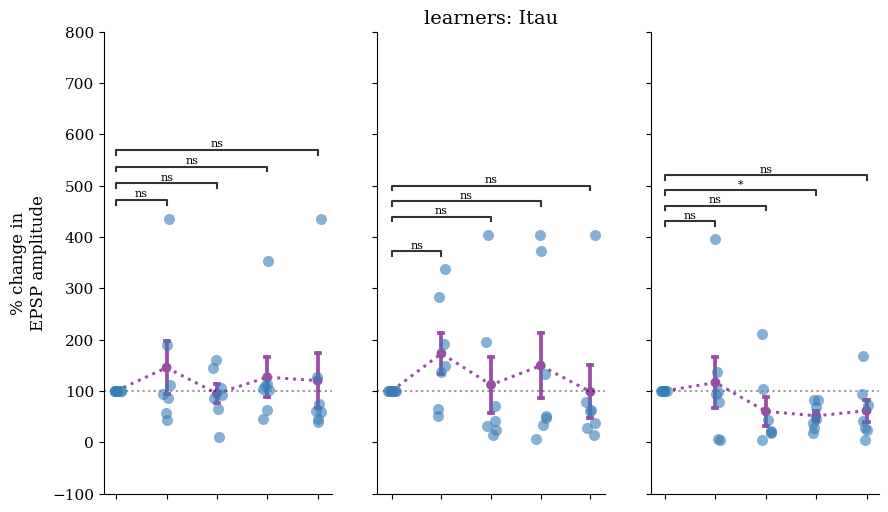

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: *
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: **
pre vs. post_3: ***
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns


/Users/anzalks/miniconda3/envs/lab_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns


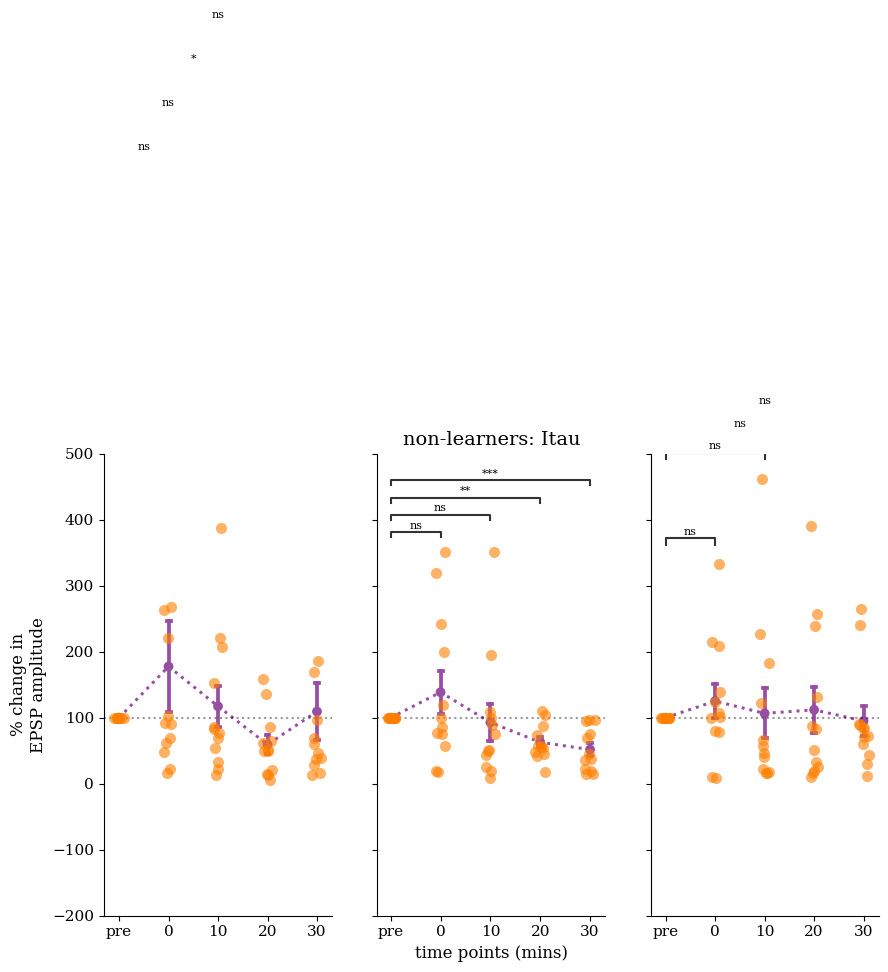

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns


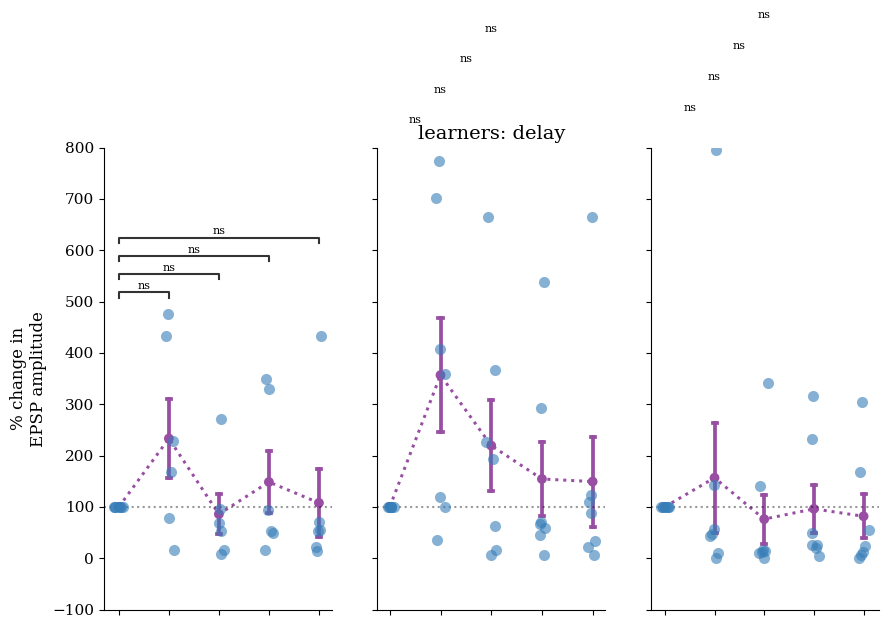

/Users/anzalks/miniconda3/envs/lab_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: **
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns


/Users/anzalks/miniconda3/envs/lab_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


pre vs. post_1: *
pre vs. post_2: ns
pre vs. post_3: ns


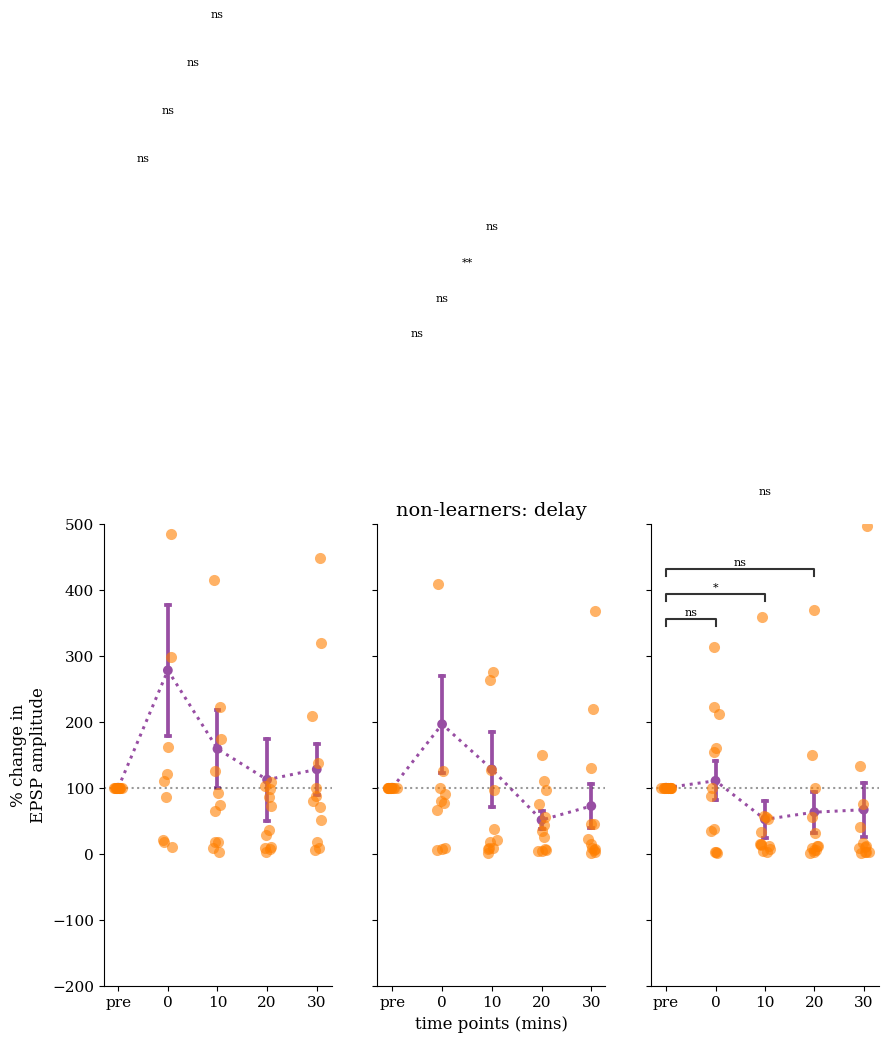

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns


/Users/anzalks/miniconda3/envs/lab_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/anzalks/miniconda3/envs/lab_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns


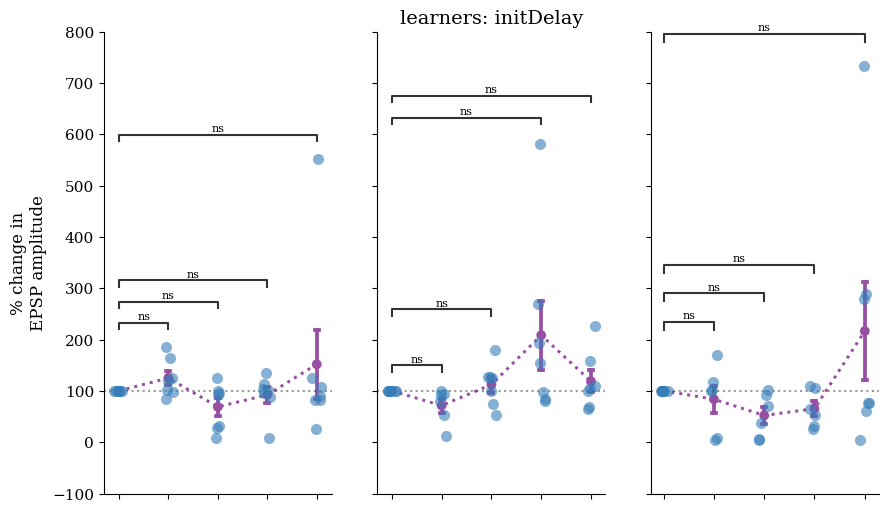

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns


/Users/anzalks/miniconda3/envs/lab_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/anzalks/miniconda3/envs/lab_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns


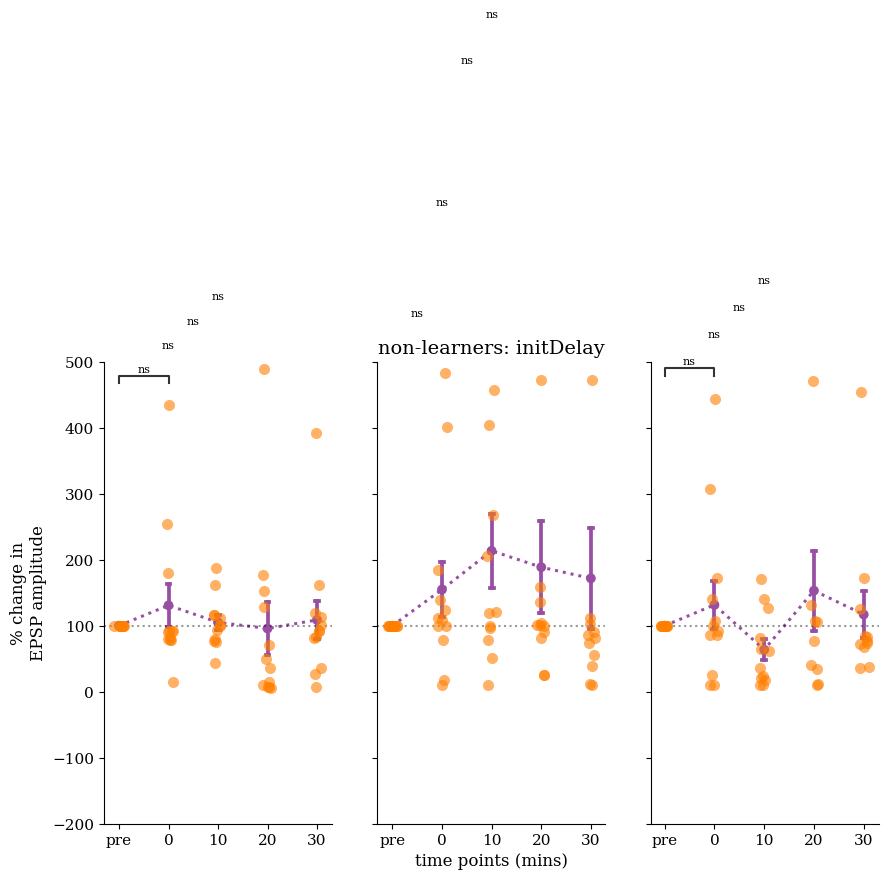

In [153]:
for feature in features_to_plot:
    plot_feature_from_curve_fit(feature)

In [ ]:
raw_data_df =pd.read_pickle("/Users/anzalks/Documents/pattern_learning_paper/plotting_scripts/python_scripts_paper_ready/data/pickle_files/all_data_with_training_df.pickle")

In [471]:
training_data= raw_data_df[raw_data_df["frame_id"].str.contains("training", case=False, na=False)]

In [476]:
training_data

cell_ID pre_post_status  sampling_rate(Hz) frame_status  \
17677060   2022_12_12_cell_5        training            20000.0     training   
17677061   2022_12_12_cell_5        training            20000.0     training   
17677062   2022_12_12_cell_5        training            20000.0     training   
17677063   2022_12_12_cell_5        training            20000.0     training   
17677064   2022_12_12_cell_5        training            20000.0     training   
...                      ...             ...                ...          ...   
394346055  2023_03_20_cell_3        training            20000.0     training   
394346056  2023_03_20_cell_3        training            20000.0     training   
394346057  2023_03_20_cell_3        training            20000.0     training   
394346058  2023_03_20_cell_3        training            20000.0     training   
394346059  2023_03_20_cell_3        training            20000.0     training   

              frame_id  trial_no  cell_trace(mV)  field_trace(mV)  \
17677060    training_0         0      -64.535522         0.043030   
17677061    training_0         0      -64.526367         0.046997   
17677062    training_0         0      -64.535522         0.049591   
17677063    training_0         0      -64.550781         0.040741   
17677064    training_0         0      -64.547729         0.033112   
...                ...       ...             ...              ...   
394346055  training_99         4      -42.633057         0.086365   
394346056  training_99         4      -42.974854         0.097656   
394346057  training_99         4      -43.295288         0.074463   
394346058  training_99         4      -43.576050         0.074463   
394346059  training_99         4      -43.850708         0.084534   

           pd_trace(V)  ttl_trace(V)   time(s)  
17677060      0.010681      0.018311  0.053002  
17677061      0.012207      0.018921  0.053052  
17677062      0.012817      0.016479  0.053102  
17677063      0.011902      0.017395  0.053152  
17677064      0.147705      1.569519  0.053202  
...                ...           ...       ...  
394346055     0.010376      0.014343  1.052796  
394346056     0.010986      0.016174  1.052846  
394346057     0.010681      0.015259  1.052896  
394346058     0.010986      0.019836  1.052946  
394346059     0.010681      0.017395  1.052996  

[2200000 rows x 11 columns]

In [514]:
def extract_training_data(cell_data):
    cell_data = cell_data[cell_data["frame_id"].str.contains("training", case=False, na=False)]
    cell_grp = cell_data.groupby(by="cell_ID")
    cell_list = []
    for cell, cell_data in cell_grp:
        sampling_rate = int(cell_data["sampling_rate(Hz)"].unique())
        trial_grp = cell_data.groupby(by="trial_no")
        for trial, trial_data in trial_grp:
            trace=trial_data["cell_trace(mV)"].to_numpy()
            trace=substract_baseline(trace,sampling_rate, 5)
            ttl=trial_data["ttl_trace(V)"].to_numpy()
            trigger=np.argmax(ttl>0.5)
            trigger_time = (trigger/sampling_rate)*1000
            trigger_val = ttl[trigger]
            cell_thresh=np.argmax(trace>0.25)
            cell_thresh_time = (cell_thresh/sampling_rate)*1000
            cell_thresh_val = trace[cell_thresh]
            cell_list.append([cell,trial,trigger_time,trigger_val,cell_thresh_time,cell_thresh_val,trace])
            clist_header=["cell_ID","trial_no","trigger_time","trigger_val","cell_thresh_time","cell_thresh_val","trace"]
    pd_cell_list =pd.concat(pd.DataFrame([i],columns=clist_header) for i in tqdm(cell_list))
    return pd_cell_list

In [561]:
training_data = extract_training_data(raw_data_df)

/var/folders/sc/cpss_44j20qbqjd8khtbyldc0000gn/T/ipykernel_42361/3546392578.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sampling_rate = int(cell_data["sampling_rate(Hz)"].unique())
100%|███████████████████████████████████████████████████████████████████████████| 110/110 [00:00<00:00, 5087.42it/s]


2022_12_19_cell_2 no selection
2022_12_19_cell_3 no selection
2023_02_28_cell_1 no selection
[0.2]


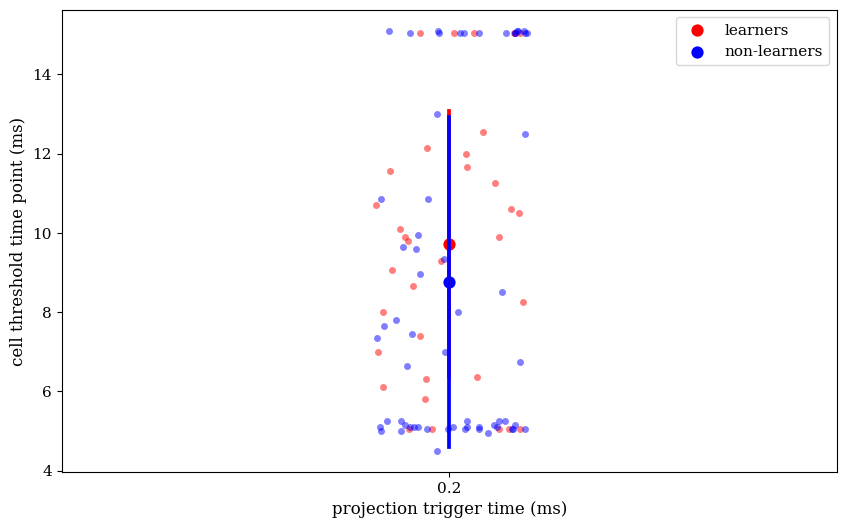

In [582]:
def plot_threshold_timing(training_data,learners,non_learners):
    fig,axs =plt.subplots(1,1)
    cell_grp = training_data.groupby(by="cell_ID")
    lrns=[]
    non_lrns=[]
    for cell, cell_data in cell_grp:
        if cell in learners:
            lrns.append(cell_data)
        elif cell in non_learners:
            non_lrns.append(cell_data)
        else:
            print(cell,"no selection")
            continue
    #print(lrns)
    #print(non_lrns)
    lrns = pd.concat(lrns)
    non_lrns = pd.concat(non_lrns)
    print(non_lrns["trigger_time"].unique())

    sns.pointplot(data=lrns,x="trigger_time", y="cell_thresh_time", color="red",errorbar="sd",dodge=True,ax=axs, label="learners")
    sns.pointplot(data=non_lrns,x="trigger_time", y="cell_thresh_time",color="blue",errorbar="sd" ,dodge=True,ax=axs, label="non-learners")

    sns.stripplot(data=lrns,x="trigger_time", y="cell_thresh_time", color="red",alpha=0.5)
    sns.stripplot(data=non_lrns,x="trigger_time", y="cell_thresh_time",color="blue",alpha=0.5)
    axs.set_ylabel("cell threshold time point (ms)")
    axs.set_xlabel("projection trigger time (ms)")
    plt.legend()
    plt.show()
    plt.close()
plot_threshold_timing(training_data,learners,non_learners)

In [34]:
from pathlib import Path
import neo.io as nio
folder_path = Path("/Users/anzalks/Documents/Expt_data/CA1_recordings/x_spread_recording_02Hz_30mins/cells_cumulated/cells_min_30mins_long")
cell_stats= pd.read_hdf("/Users/anzalks/Documents/pattern_learning_paper/plotting_scripts/python_scripts_paper_ready/data/pickle_files/cell_stats.h5")

In [285]:
def list_folder(p):
    f_list = []
    f_list = list(p.glob('*_cell_*'))
    f_list.sort()
    return f_list

def list_files(p):
    f_list = []
    f_list=list(p.glob('**/*abf'))
    f_list.sort()
    return f_list

def protocol_file_name(file_name):
    f = str(file_name)
    reader = nio.AxonIO(f)
    protocol_name = reader._axon_info['sProtocolPath']
    protocol_name = str(protocol_name).split('\\')[-1]
    protocol_name = protocol_name.split('.')[-2]
    #print(f"protocol_name:{protocol_name}.....")
    return protocol_name

def current_injected(reader):
    protocol_raw = reader.read_raw_protocol()
    protocol_raw = protocol_raw[0]
    protocol_trace = []
    for n in protocol_raw:
        protocol_trace.append(n[0])
    #i_min = np.abs(np.min(protocol_trace))
    #i_max = np.abs(np.max(protocol_trace))
    #i_av = np.around((i_max-i_min),2)
    return protocol_trace#i_av

def abf_to_df(file_name):
    df_from_abf = []
    f = str(file_name)
    reader = nio.AxonIO(f)
    channels = reader.header['signal_channels']
    chan_count = len(channels)
    file_id = file_name.stem
    block  = reader.read_block(signal_group_mode='split-all')
    segments = block.segments
    sample_trace = segments[0].analogsignals[0]
    sampling_rate = sample_trace.sampling_rate.magnitude
    sampling_rate_unit = str(sample_trace.sampling_rate.units).split()[-1]
    ti = sample_trace.t_start
    tf = sample_trace.t_stop
    protocol_trace_list=current_injected(reader)
    #print(protocol_trace_list)
    for s, segment in enumerate(segments):
        df_segment = pd.DataFrame()                                                   
        cell_signal = segment.analogsignals[0]
        cell_Signal_unit = str(cell_signal.units).split()[-1]
        cell_trace = np.hstack(np.ravel(np.array(cell_signal)))                        
        t = np.linspace(0,float(tf-ti),len(cell_trace))
        trial_no = s
        trial_no = [trial_no]*len(t)
        df_segment['trial_no']=trial_no
        df_segment[f'cell_trace({cell_Signal_unit})']=cell_trace
        df_segment["injected_current(pA)"]=protocol_trace_list[s]
        df_segment['time(s)']=t
        df_from_abf.append(df_segment)
    df_from_abf = pd.concat(df_from_abf,ignore_index=True)
    df_from_abf.insert(loc=0, column=f'sampling_rate({sampling_rate_unit})', value=sampling_rate)
    return df_from_abf

def extract_first_spike(cell_data):
    trace = cell_data["cell_trace(mV)"].to_numpy()
    peaks, properties = scipy.signal.find_peaks(trace, height=0)
    first_spike_idx=peaks[0]
    first_spike = [cell_data.iloc[first_spike_idx],first_spike_idx]
    first_spike_data = first_spike[0]
    return first_spike

def extract_spike_frequency(trial_data,traial_no):
    sampling_rate=trial_data["sampling_rate(Hz)"].unique()[0]
    i_trace = trial_data["injected_current(pA)"].to_numpy()
    cell_trace = trial_data["cell_trace(mV)"].to_numpy()
    injected_current = np.max(i_trace)
    start_idx_injection = np.argmax(i_trace)
    end_idx_injection = start_idx_injection+int(0.25*sampling_rate) # 250 ms injection time for all protocols
    spike_trace=cell_trace[start_idx_injection:end_idx_injection]
    peaks, properties = scipy.signal.find_peaks(spike_trace, height=0)
    number_spikes = len(peaks)
    time_current_inj = (end_idx_injection-start_idx_injection)/sampling_rate
    spike_frequency = number_spikes/time_current_inj

    #print(f"idx_len_c_inj: {idx_len_c_inj[0][0]}")
    #plt.plot(cell_trace)
    #plt.scatter(peaks+start_idx_injection,cell_trace[peaks+start_idx_injection],c='r')
    #plt.axvline(start_idx_injection,c='r')
    #plt.axvline(end_idx_injection,c='r')
    #plt.ylim(-90,100)
    #plt.show()
    #plt.close()
    #print(f"injected_current: {injected_current}, time injection : {time_current_inj}, number_spikes: {number_spikes}, spike_frequency: {spike_frequency}")
    return spike_frequency, injected_current
    

In [102]:
cells = list_folder(folder_path) 

In [103]:
h_cells=list(cell_stats.index)
cell_firing_data_all_cells=[]
for cell in tqdm(cells):
    if cell.stem in h_cells:
        abf_list =list_files(cell)
        for abf in abf_list:
            protocol_name = protocol_file_name(abf)
            #print(protocol_name)
            if "cell_threshold" not in protocol_name:
                continue
            else:
                #print(protocol_name,abf)
                firing_data_df = abf_to_df(abf)
                firing_data_df.insert(loc=0, column='cell_ID', value=cell.stem)
                cell_firing_data_all_cells.append(firing_data_df)
cell_firing_data_all_cells= pd.concat(cell_firing_data_all_cells,ignore_index=True)
cell_firing_data_all_cells.reset_index(drop=True)

100%|█████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.30it/s]


cell_ID  sampling_rate(Hz)  trial_no  cell_trace(mV)  \
0        2022_12_12_cell_2            20000.0         0      -65.921021   
1        2022_12_12_cell_2            20000.0         0      -65.917969   
2        2022_12_12_cell_2            20000.0         0      -65.924072   
3        2022_12_12_cell_2            20000.0         0      -65.933228   
4        2022_12_12_cell_2            20000.0         0      -65.914917   
...                    ...                ...       ...             ...   
6399995  2023_03_22_cell_2            20000.0        19      -72.689819   
6399996  2023_03_22_cell_2            20000.0        19      -72.686768   
6399997  2023_03_22_cell_2            20000.0        19      -72.650146   
6399998  2023_03_22_cell_2            20000.0        19      -72.653198   
6399999  2023_03_22_cell_2            20000.0        19      -72.680664   

         injected_current(pA)  time(s)  
0                         0.0  0.00000  
1                         0.0  0.00005  
2                         0.0  0.00010  
3                         0.0  0.00015  
4                         0.0  0.00020  
...                       ...      ...  
6399995                   0.0  0.49980  
6399996                   0.0  0.49985  
6399997                   0.0  0.49990  
6399998                   0.0  0.49995  
6399999                   0.0  0.50000  

[6400000 rows x 6 columns]

In [286]:
cell_grp = cell_firing_data_all_cells.groupby(by="cell_ID")
firing_properties=[]
for cell, cell_data in cell_grp:
    trial_grp = cell_data.groupby(by="trial_no")
    for trial, trial_data in trial_grp:
        trial_df=pd.DataFrame()
        spike_frequency, injected_current = extract_spike_frequency(trial_data,trial)
        trial_df["cell_ID"]=[cell]
        trial_df["trial_no"]=trial
        trial_df["spike_frequency"]=spike_frequency
        trial_df["injected_current"]=injected_current
        firing_properties.append(trial_df)
firing_properties = pd.concat(firing_properties).reset_index(drop=True)        
        
"""    
    
    first_spike = extract_first_spike(cell_data)
    first_spike_data = first_spike[0]
    first_spike_idx=first_spike[1]
    injected_current=first_spike_data['injected_current(pA)']
    cell_df["cell_ID"]=[cell]
    cell_df["spike_frequency"]=spike_frequency
    cell_df["cell_threshold"]=injected_current
    firing_properties.append(cell_df)
firing_properties = pd.concat(firing_properties).reset_index(drop=True)
"""

'    \n    \n    first_spike = extract_first_spike(cell_data)\n    first_spike_data = first_spike[0]\n    first_spike_idx=first_spike[1]\n    injected_current=first_spike_data[\'injected_current(pA)\']\n    cell_df["cell_ID"]=[cell]\n    cell_df["spike_frequency"]=spike_frequency\n    cell_df["cell_threshold"]=injected_current\n    firing_properties.append(cell_df)\nfiring_properties = pd.concat(firing_properties).reset_index(drop=True)\n'

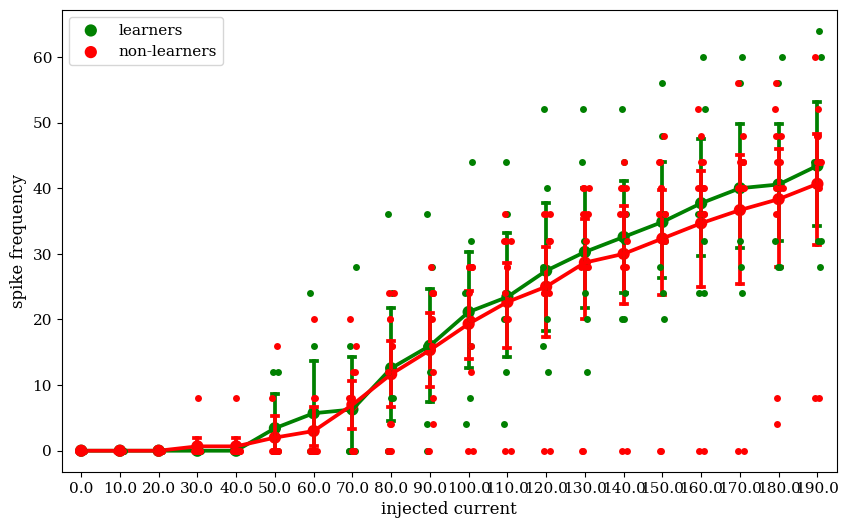

In [324]:
sns.stripplot(data=firing_properties[firing_properties["cell_ID"].isin(learners)],x="injected_current",y="spike_frequency",color="green")
sns.pointplot(data=firing_properties[firing_properties["cell_ID"].isin(learners)],x="injected_current",y="spike_frequency",color="green", capsize=0.15,label="learners")
sns.stripplot(data=firing_properties[firing_properties["cell_ID"].isin(non_learners)],x="injected_current",y="spike_frequency",color="red")
sns.pointplot(data=firing_properties[firing_properties["cell_ID"].isin(non_learners)],x="injected_current",y="spike_frequency",color="red",capsize=0.15, label="non-learners")
plt.ylabel("spike frequency")
plt.xlabel("injected current")
plt.legend()

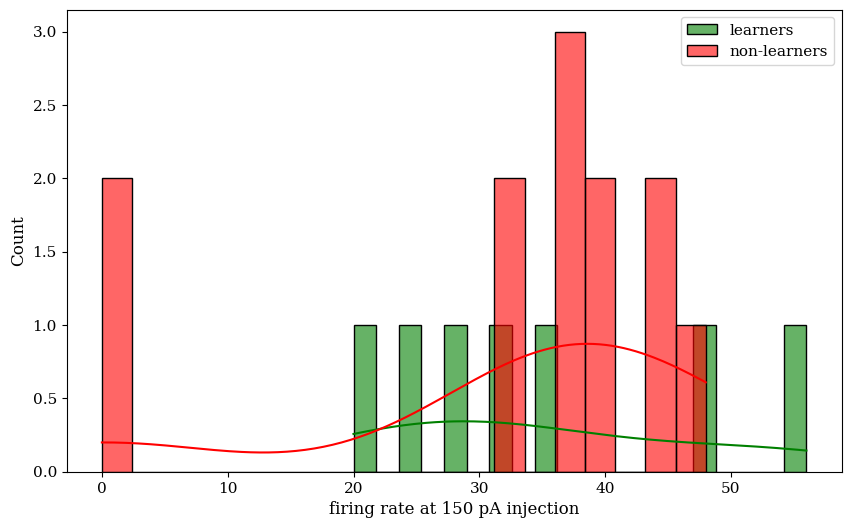

In [305]:
sns.histplot(data= firing_properties[(firing_properties["cell_ID"].isin(learners))&(firing_properties["injected_current"]==150)], x="spike_frequency", bins=20, kde=True, color="green", edgecolor='black',alpha=0.6,label="learners")
sns.histplot(data= firing_properties[(firing_properties["cell_ID"].isin(non_learners))&(firing_properties["injected_current"]==150)], x="spike_frequency", bins=20, kde=True, color="red", edgecolor='black',alpha=0.6,label="non-learners")
plt.xlabel("firing rate at 150 pA injection")
plt.legend()

In [256]:
firing_properties["cell_ID"]

0     2022_12_12_cell_2
1     2022_12_12_cell_5
2     2022_12_19_cell_2
3     2022_12_19_cell_3
4     2022_12_21_cell_1
5     2022_12_29_cell_1
6     2022_12_30_cell_1
7     2023_01_09_cell_1
8     2023_01_09_cell_2
9     2023_01_09_cell_3
10    2023_01_10_cell_1
11    2023_01_10_cell_2
12    2023_01_10_cell_3
13    2023_01_27_cell_1
14    2023_01_27_cell_2
15    2023_02_23_cell_1
16    2023_02_24_cell_1
17    2023_02_24_cell_2
18    2023_02_24_cell_3
19    2023_02_26_cell_1
20    2023_02_27_cell_1
21    2023_02_27_cell_2
22    2023_02_28_cell_1
23    2023_03_17_cell_1
24    2023_03_17_cell_2
25    2023_03_18_cell_1
26    2023_03_18_cell_2
27    2023_03_20_cell_1
28    2023_03_20_cell_2
29    2023_03_20_cell_3
30    2023_03_22_cell_1
31    2023_03_22_cell_2
Name: cell_ID, dtype: object